In [ ]:
!pip list

Package                          Version
-------------------------------- ---------------------
absl-py                          1.4.0
aiohttp                          3.9.5
aiosignal                        1.3.1
alabaster                        0.7.16
albumentations                   1.3.1
altair                           4.2.2
annotated-types                  0.6.0
anyio                            3.7.1
appdirs                          1.4.4
argon2-cffi                      23.1.0
argon2-cffi-bindings             21.2.0
array_record                     0.5.1
arviz                            0.15.1
astropy                          5.3.4
astunparse                       1.6.3
async-timeout                    4.0.3
atpublic                         4.1.0
attrs                            23.2.0
audioread                        3.0.1
autograd                         1.6.2
Babel                            2.14.0
backcall                         0.2.0
beautifulsoup4                   4.12.3


# Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import Statements

In [ ]:
import torch
import torch.nn as tnn
import torch.cuda as tcuda
import numpy as NumPy

# If CUDA is available, run code on GPU. Else, run code on CPU.
if tcuda.is_available():
  this_device = torch.device('cuda:0')
else:
  this_device = torch.device('cpu')

# Load Datasets

In [ ]:
dataset_used = 'DFAUST'

## Subsampling Size

In [ ]:
point_cloud_frame_subsampling_size_DFAUST = 1024

## Training/Validation/Test Split Percentage

In [ ]:
training_split = 0.60
validation_split = 0.30
test_split = 0.10

## IKEA ASM Dataset

### Load the IKEA ASM Dataset's video.

In [ ]:
if dataset_used == "IKEA-ASM":
  npz_file = '/content/drive/MyDrive/Colab Notebooks/COMPSCI 674/Final Project/\
IKEA/ANU_ikea_dataset_point\
_cloud_video/processed_frames/Lack_Coffee_Table/0004_b\
lack_floor_06_03_2019_08_21_11_46/dev3/point_cloud_video.npz'
  ikea_asm_pt_cld_video = NumPy.load(npz_file)['frames']

  # Print the shape of the loaded dataset.
  print(ikea_asm_pt_cld_video.shape)

### Create Tensors of the IKEA ASM Dataset's Video and Its Labels

In [ ]:
if dataset_used == "IKEA-ASM":
  # Set the num_frames, T and N variables using the data from the IKEA ASM dataset.
  num_frames, N, _3 = ikea_asm_pt_cld_video.shape
  T = num_frames - 1

  # Make S hold the point cloud video from the IKEA ASM dataset.
  S = torch.from_numpy(ikea_asm_pt_cld_video).to(device = this_device).unsqueeze(0)

In [ ]:
if dataset_used == "IKEA-ASM":
  # Read the action annotations from an .npy file into a variable.
  action_annotations_path = '/content/drive/MyDrive/Colab Notebooks/COMPSCI 674/Final Project/IKEA/action_annotations/gt_action.npy'
  actions = NumPy.load(action_annotations_path, allow_pickle = True)

  # Display information about the action annotations.
  print(type(actions))
  print(actions.dtype)
  print(actions.shape)
  print(actions.ndim)

  # Convert the action annotations to a dictionary and store the dictionary in a variable.
  actions_list = actions.tolist()

  # Display information about the actions annotation dictionary.
  print(type(actions_list))
  print(actions_list.keys())
  print(len(actions_list['scan_name']))
  len(actions_list['gt_labels'])
  # help(actions_list['scan_name'])

  # Store the index of the loaded point cloud video's action annotations in a variable.
  index_of_pt_cld_video = actions_list['scan_name'].index('Lack_Coffee_Table/0004_black_floor_06_03_2019_08_21_11_46')

  # Store the ground truth labels of the loaded point cloud video in a variable.
  ground_truth_labels = torch.from_numpy(actions_list['gt_labels'][index_of_pt_cld_video])

  # Display information about the ground truth labels of the loaded point cloud video.
  ground_truth_labels.shape

  # Store the ground truth labels of the first 1500 frames of the loaded point cloud video in a variable.
  ikea_asm_pt_cld_video_action_labels = ground_truth_labels[:1500].unsqueeze(0)

  # Print information about the action labels of the point cloud video frames.
  print(torch.max(ikea_asm_pt_cld_video_action_labels))
  print(torch.min(ikea_asm_pt_cld_video_action_labels))

  # Store the number of action classes in a variable.
  num_action_classes = torch.max(ikea_asm_pt_cld_video_action_labels) + 1

## MSR-Action3D Dataset

### Load the MSR-Action3D Dataset

In [ ]:
if dataset_used == "MSR-Action3D":
  import pickle
  import sys

  # Load the MSR-Action3D dataset's depth map sequences and their class labels.
  msr_action3d_path = '/content/drive/MyDrive/Colab Notebooks/COMPSCI 674/Final Project/MSRAction3DFPS/MSRAction3D_fps/'
  #msr_action3d_path = '/content/drive/MyDrive/Colab Notebooks/'

  with open(msr_action3d_path + 'MSRAction3D_FPS_Videos.pickle' , mode = 'rb') as msr_action3d_pickle_file:
    msr_action3d_depth_map_sequences = pickle.load(msr_action3d_pickle_file)
  msr_action3d_depth_map_sequence_labels = NumPy.load(msr_action3d_path + 'MSRAction3D_FPS_Video_Labels.npz')['labels']

In [ ]:
if dataset_used == "MSR-Action3D":
  # Print out the shapes of the depth map sequences in the MSR-Action3D dataset.
  for index, video in enumerate(msr_action3d_depth_map_sequences):
    print(index + 1, "-->", video.shape)

In [ ]:
if dataset_used == "MSR-Action3D":
  num_action_classes = 20

### Create the MSRAction3DDataset Class to Batch Depth Map Subsequences.

In [ ]:
if dataset_used == "MSR-Action3D":
  class MSRAction3DDataset(torch.utils.data.Dataset):
    def __init__(self, labels, subsequences, start_index, end_index):
      # Call the __init__ function of the Dataset superclass.
      super(MSRAction3DDataset, self).__init__()

      # Store the labels and subsequences in class variables.
      self.labels = labels[start_index: end_index].to(device = this_device)
      self.subsequences = subsequences[start_index: end_index].to(device = this_device)
    def __getitem__(self, integral_key):
      # Implemented the __getitem__ method of this dataset.
      return (self.labels[integral_key], self.subsequences[integral_key])
    def __len__(self):
      # Implemented the __len__ method of this dataset.
      return len(self.labels)
    def __getitems__(self, batch_indices):
      # Implemented the __getitems__ method of this dataset.
      return (self.labels[batch_indices], self.subsequences[batch_indices])

### Construct a DataLoader to Batch Samples from MSRAction3D Dataset

In [ ]:
if dataset_used == "MSR-Action3D":
  # Store the number of deoth maps per clip in a variable.
  clip_size = 8

  # Initialize a dictionary to hold the MSRAction3D clips and their labels.
  MSRAction3D_dataset = {'labels': [], 'clips': []}

  # Loop through the depth map sequences of the MSRAction3D Dataset.
  for index, depth_map_sequence in enumerate(msr_action3d_depth_map_sequences):
    label = msr_action3d_depth_map_sequence_labels[index]
    num_depth_maps = depth_map_sequence.shape[1]
    clips = list(torch.Tensor(depth_map_sequence[0]).split(clip_size))
    if num_depth_maps % clip_size != 0:
      clips = clips[:-1]
    MSRAction3D_dataset['labels'].append(label + torch.zeros((num_depth_maps // clip_size, )))
    [MSRAction3D_dataset['clips'].append(clip[None]) for clip in clips]

  # Concatenate all the label Tensors in the dataset together to form a single Tensor. Update the
  # 'labels' key with the single Tensor. Similarly, concatenate all the clip Tensors into a single
  # Tensor and store the Tensor at the 'clips' key in the DFAUST dataset.
  MSRAction3D_dataset['labels'] = torch.concatenate(MSRAction3D_dataset['labels'])
  MSRAction3D_dataset['clips'] = torch.concatenate(MSRAction3D_dataset['clips'])

  # Print out the shapes of the labels and the clips.
  print(MSRAction3D_dataset['labels'].shape, MSRAction3D_dataset['clips'].shape)

  # Store the training, validation and testing datasets in three separate variables.
  training_msraction3d_dataset = MSRAction3DDataset(
          MSRAction3D_dataset['labels'],
          MSRAction3D_dataset['clips'],
          0,
          int(MSRAction3D_dataset['labels'].shape[0] * training_split)
          )
  validation_msraction3d_dataset = MSRAction3DDataset(
          MSRAction3D_dataset['labels'],
          MSRAction3D_dataset['clips'],
          int(MSRAction3D_dataset['labels'].shape[0] * training_split),
          int(MSRAction3D_dataset['labels'].shape[0] * (training_split + validation_split))
          )
  testing_msraction3d_dataset = MSRAction3DDataset(
          MSRAction3D_dataset['labels'],
          MSRAction3D_dataset['clips'],
          int(MSRAction3D_dataset['labels'].shape[0] * (training_split + validation_split)),
          MSRAction3D_dataset['labels'].shape[0]
          )

  # Store the batch size to use during training.
  dataset_batch_size = 32

  # Store the objects that load the training dataset, the validation dataset and the test dataset
  # in variables.
  training_data_loader = torch.utils.data.DataLoader(
      dataset = training_msraction3d_dataset,
      batch_sampler = torch.utils.data.BatchSampler(
          sampler = torch.utils.data.RandomSampler(data_source = training_msraction3d_dataset),
          batch_size = dataset_batch_size,
          drop_last = True),
      collate_fn = lambda batch: batch
  )
  validation_data_loader = torch.utils.data.DataLoader(
      dataset = validation_msraction3d_dataset,
      batch_sampler = torch.utils.data.BatchSampler(
          sampler = torch.utils.data.RandomSampler(data_source = validation_msraction3d_dataset),
          batch_size = dataset_batch_size,
          drop_last = True),
      collate_fn = lambda batch: batch
  )
  testing_data_loader = torch.utils.data.DataLoader(
      dataset = testing_msraction3d_dataset,
      batch_sampler = torch.utils.data.BatchSampler(
          sampler = torch.utils.data.RandomSampler(data_source = testing_msraction3d_dataset),
          batch_size = dataset_batch_size,
          drop_last = True),
      collate_fn = lambda batch: batch
  )

  # Delete the old MSRAction3D dataset variables to save memory.
  # del msraction3d_dataset, msraction3d_data_loader

  # Print out the shapes of the batches in the MSRAction3D dataset.
  for batch in training_data_loader:
    labels, clips = batch
    print(labels.shape, clips.shape)

## DFAUST

### Load the DFAUST dataset

In [ ]:
if dataset_used == "DFAUST":
  import pickle

  # Load the DFAUST point cloud videos of the subject 50020 from Google Drive.
  dfaust_path = '/content/drive/MyDrive/Colab Notebooks/COMPSCI 674/Final Project/DFAUST/downloads/scans/50020/'
  with open(dfaust_path + '50020.pickle' , mode = 'rb') as dfaust_pickle_file:
    dfaust_pt_cld_videos_labels = pickle.load(dfaust_pickle_file)

  # Store the number of action classes in the DFAUST dataset in a variable.
  num_action_classes = 13

### Downsample Each Point Cloud Frame

Downsampling each point cloud frame that has around 100K points to have a number of points that isn't too large to do computation on.

In [ ]:
if dataset_used == "DFAUST":
  # Initialize a random number generator.
  random_number_generator = NumPy.random.default_rng()

  # Loop through the keys of the DFAUST dataset dictionary.
  for action in dfaust_pt_cld_videos_labels:
    # Get the label to video dictionary of the current action.
    label_to_video_dict = dfaust_pt_cld_videos_labels[action]

    # Print out information about the current action and its label to video dictionary.
    print("Action: {:20s} Label: {:2d} Video Frame Length: {:3d}".format(
        action.name,
        label_to_video_dict['label'],
        len(label_to_video_dict['video'])
        )
    )

    # Store the number of frames that are in the video of the current action in a variable.
    number_of_frames_in_video = len(label_to_video_dict['video'])

    # Loop through each frame of the video of the current action.
    for i in range(number_of_frames_in_video):
      # Uniformly randomly sample a small number of points from the current
      # point cloud frame and replace the current point cloud frame with the
      # random sample. Output the change in the dimensions of the current frame.
      print("{}->".format(label_to_video_dict['video'][i].shape), end = '')
      dfaust_pt_cld_videos_labels[action]['video'][i] = random_number_generator.choice(
        label_to_video_dict['video'][i],
        size = point_cloud_frame_subsampling_size_DFAUST,
        replace = False,
        axis = 0
        )
      print("{}".format(dfaust_pt_cld_videos_labels[action]['video'][i].shape), end = '')

      if i < number_of_frames_in_video - 1:
        # If the current frame isn't the last frame, print a string that separates the output.
        print(", ", end = '')

    # Concatenate the samples of each point cloud frames of the current video together to make
    # a new video. Replace the old video with the new video in the DFAUST dataset.
    dfaust_pt_cld_videos_labels[action]['video'] = torch.Tensor(dfaust_pt_cld_videos_labels[action]['video'])

    # Print out information about the current action and its label to video dictionary.
    print("\nAction: {:20s} Label: {:2d} Video Shape: {}\n\n".format(
      action.name,
      label_to_video_dict['label'],
      tuple(dfaust_pt_cld_videos_labels[action]['video'].shape)
      )
    )

Action: shake_shoulders      Label:  0 Video Frame Length: 144
(102050, 3)->(1024, 3), (101905, 3)->(1024, 3), (101921, 3)->(1024, 3), (102014, 3)->(1024, 3), (102033, 3)->(1024, 3), (101794, 3)->(1024, 3), (101550, 3)->(1024, 3), (101553, 3)->(1024, 3), (101298, 3)->(1024, 3), (101123, 3)->(1024, 3), (100525, 3)->(1024, 3), (100287, 3)->(1024, 3), (100115, 3)->(1024, 3), (100013, 3)->(1024, 3), (99602, 3)->(1024, 3), (99472, 3)->(1024, 3), (99330, 3)->(1024, 3), (99069, 3)->(1024, 3), (98779, 3)->(1024, 3), (98843, 3)->(1024, 3), (98747, 3)->(1024, 3), (98848, 3)->(1024, 3), (99093, 3)->(1024, 3), (99211, 3)->(1024, 3), (99146, 3)->(1024, 3), (99168, 3)->(1024, 3), (99028, 3)->(1024, 3), (99304, 3)->(1024, 3), (99263, 3)->(1024, 3), (99290, 3)->(1024, 3), (99601, 3)->(1024, 3), (99896, 3)->(1024, 3), (100052, 3)->(1024, 3), (100315, 3)->(1024, 3), (100372, 3)->(1024, 3), (100322, 3)->(1024, 3), (99985, 3)->(1024, 3), (99961, 3)->(1024, 3), (99703, 3)->(1024, 3), (99824, 3)->(1024, 3),

<ipython-input-16-977ef6b2baf4>:41: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  dfaust_pt_cld_videos_labels[action]['video'] = torch.Tensor(dfaust_pt_cld_videos_labels[action]['video'])



Action: shake_shoulders      Label:  0 Video Shape: (144, 1024, 3)


Action: jiggle_on_toes       Label:  1 Video Frame Length: 201
(102407, 3)->(1024, 3), (102462, 3)->(1024, 3), (101848, 3)->(1024, 3), (102271, 3)->(1024, 3), (102253, 3)->(1024, 3), (102118, 3)->(1024, 3), (101887, 3)->(1024, 3), (101900, 3)->(1024, 3), (101775, 3)->(1024, 3), (101630, 3)->(1024, 3), (101646, 3)->(1024, 3), (101338, 3)->(1024, 3), (101063, 3)->(1024, 3), (100702, 3)->(1024, 3), (100289, 3)->(1024, 3), (99639, 3)->(1024, 3), (98934, 3)->(1024, 3), (98493, 3)->(1024, 3), (97767, 3)->(1024, 3), (97335, 3)->(1024, 3), (97224, 3)->(1024, 3), (97567, 3)->(1024, 3), (97994, 3)->(1024, 3), (99439, 3)->(1024, 3), (100264, 3)->(1024, 3), (100740, 3)->(1024, 3), (101344, 3)->(1024, 3), (101995, 3)->(1024, 3), (102482, 3)->(1024, 3), (102900, 3)->(1024, 3), (103438, 3)->(1024, 3), (104256, 3)->(1024, 3), (105065, 3)->(1024, 3), (105856, 3)->(1024, 3), (106194, 3)->(1024, 3), (106357, 3)->(1024, 3), (106532, 3)-

### DFAUST Dataset Class for Batching Video Clips

In [ ]:
if dataset_used == "DFAUST":
  class DFAUSTDataset(torch.utils.data.Dataset):
    def __init__(self, labels, clips, start_index, end_index):
      # Call the __init__ function of the Dataset superclass.
      super(DFAUSTDataset, self).__init__()

      # Store the labels and video clips in class variables.
      self.labels = labels.to(device = this_device)[start_index:end_index]
      self.clips = clips.to(device = this_device)[start_index:end_index]
    def __getitem__(self, integral_key):
      # Implemented the __getitem__ method of this dataset.
      return (self.labels[integral_key], self.clips[integral_key])
    def __len__(self):
      # Implemented the __len__ method of this dataset.
      return len(self.labels)
    def __getitems__(self, batch_indices):
      # Implemented the __getitems__ method of this dataset.
      return (self.labels[batch_indices], self.clips[batch_indices])

### Create video clips from the videos of the DFAUST dataset

In [ ]:
if dataset_used == "DFAUST":
  # Store the number of frames per clip in a variable.
  clip_size = 64

  # Initialize a dictionary to hold the DFAUST clips and their labels.
  dfaust_dataset = {'labels': [], 'clips': []}

  # Loop over actions in the DFAUST dataset.
  for action in dfaust_pt_cld_videos_labels:
    label_to_video_dict = dfaust_pt_cld_videos_labels[action]
    label = label_to_video_dict['label']
    video = label_to_video_dict['video']
    num_frames_in_current_video = video.shape[0]
    clips = list(video.split(clip_size))
    if num_frames_in_current_video % clip_size != 0:
      clips = clips[:-1]
    dfaust_dataset['labels'].append(label + torch.zeros((num_frames_in_current_video // clip_size, )))
    [dfaust_dataset['clips'].append(clip.unsqueeze(0)) for clip in clips]

  # Concatenate all the label Tensors in the dataset together to form a single Tensor. Update the
  #'labels' key with the single Tensor. Similarly, concatenate all the clip Tensors into a single
  # Tensor and store the Tensor at the 'clips' key in the DFAUST dataset.
  dfaust_dataset['labels'] = torch.concatenate(dfaust_dataset['labels'])
  dfaust_dataset['clips'] = torch.concatenate(dfaust_dataset['clips'])

  # Print out the shapes of the labels and the clips.
  print(dfaust_dataset['labels'].shape, dfaust_dataset['clips'].shape)

  # Store the training, validation and testing datasets in three separate variables.
  training_dfaust_dataset = DFAUSTDataset(
          dfaust_dataset['labels'],
          dfaust_dataset['clips'],
          0,
          int(dfaust_dataset['labels'].shape[0] * training_split)
          )
  validation_dfaust_dataset = DFAUSTDataset(
          dfaust_dataset['labels'],
          dfaust_dataset['clips'],
          int(dfaust_dataset['labels'].shape[0] * training_split),
          int(dfaust_dataset['labels'].shape[0] * (training_split + validation_split))
          )
  testing_dfaust_dataset = DFAUSTDataset(
          dfaust_dataset['labels'],
          dfaust_dataset['clips'],
          int(dfaust_dataset['labels'].shape[0] * (training_split + validation_split)),
          dfaust_dataset['labels'].shape[0]
          )

  # Store the batch size to use during training.
  dataset_batch_size = 4

  # Store the objects that load the training dataset, the validation dataset and the test dataset
  # in variables.
  training_data_loader = torch.utils.data.DataLoader(
      dataset = training_dfaust_dataset,
      batch_sampler = torch.utils.data.BatchSampler(
          sampler = torch.utils.data.RandomSampler(data_source = training_dfaust_dataset),
          batch_size = dataset_batch_size,
          drop_last = True),
      collate_fn = lambda batch: batch
  )
  validation_data_loader = torch.utils.data.DataLoader(
      dataset = validation_dfaust_dataset,
      batch_sampler = torch.utils.data.BatchSampler(
          sampler = torch.utils.data.RandomSampler(data_source = validation_dfaust_dataset),
          batch_size = dataset_batch_size,
          drop_last = True),
      collate_fn = lambda batch: batch
  )
  testing_data_loader = torch.utils.data.DataLoader(
      dataset = testing_dfaust_dataset,
      batch_sampler = torch.utils.data.BatchSampler(
          sampler = torch.utils.data.RandomSampler(data_source = testing_dfaust_dataset),
          batch_size = dataset_batch_size,
          drop_last = True),
      collate_fn = lambda batch: batch
  )

  # Delete the old DFAUST dataset variables to save memory.
  #del dfaust_dataset, dfaust_pt_cld_videos_labels

  # Print out the shapes of the batches in the DFAUST dataset.
  for batch in training_data_loader:
    labels, clips = batch
    print(labels.shape, clips.shape)

torch.Size([40]) torch.Size([40, 64, 1024, 3])
torch.Size([4]) torch.Size([4, 64, 1024, 3])
torch.Size([4]) torch.Size([4, 64, 1024, 3])
torch.Size([4]) torch.Size([4, 64, 1024, 3])
torch.Size([4]) torch.Size([4, 64, 1024, 3])
torch.Size([4]) torch.Size([4, 64, 1024, 3])
torch.Size([4]) torch.Size([4, 64, 1024, 3])


# General Code Cells

torch.split, torch.cat, modifying tensors, inf, grad, tuples, torch.flatten, torch.reshape

In [ ]:
tsor1 = torch.rand((100, 10))
tsor2 = torch.rand((10, 10))
tsor3 = torch.cat((tsor1, tsor2))
print(tsor1.shape, tsor2.shape, tsor3.shape)

tsor1 = torch.rand((100,))
tsor2 = torch.rand((10, ))
tsor3 = torch.cat((tsor1, tsor2), dim = 0)
print(tsor1.shape, tsor2.shape, tsor3.shape)

tsor1_cp, tsor2_cp = torch.split(tsor3, [100, 10])
print(tsor1_cp.shape, tsor2_cp.shape)

print(torch.rand((4, 5, 6)).flatten(start_dim = 1).shape)

torch.Size([100, 10]) torch.Size([10, 10]) torch.Size([110, 10])
torch.Size([100]) torch.Size([10]) torch.Size([110])
torch.Size([100]) torch.Size([10])
torch.Size([4, 30])


In [ ]:
def modify_list_or_tensor(x):
  x[0] *= 100000
  return x

tsor1 = torch.rand((10, 3))
modify_list_or_tensor(tsor1)
print(tsor1)

list1 = list(tsor1)
list1 = modify_list_or_tensor(list1)
print(list1)

list2 = [tsor1.new_full((4, 4), 1), tsor1.new_full((4, 4), 2), tsor1.new_full((4, 4), 3)]
tsor2 = torch.cat(list2)
print(tsor2, tsor2.shape)

print(float("infinity"))

tsor3 = torch.rand((3, 4, 5))
conv_1 = tnn.Conv2d(3, 3, 2, 1, 1)
conv_2 = tnn.Conv2d(3, 3, 4, 1, 1)
conv_1.weight.requires_grad = False
conv_1.weight *= 0
tsor4 = torch.Tensor([[4, 4], [4, 4]])
print(conv_1.weight.shape, tsor4.shape)
conv_1.weight += tsor4
conv_1.weight
relu_1 = tnn.ReLU()
output = torch.mean(conv_2(relu_1(conv_1(torch.rand((10, 3,  40, 40))))))
output.backward()
print(output.grad, conv_1.weight.grad, conv_2.weight.grad)

fc_1 = tnn.Linear(10, 30)
fc_2 = tnn.Linear(30, 1)
fc_2_weight = fc_2.weight
fc_2.weight.requires_grad = False
input = torch.rand((1, 10))
input_tiled = input.T + torch.zeros((10, 30))
fc_2(fc_1(input)).backward()
print(fc_1.weight.grad, fc_2.weight.grad, input)
print(input_tiled * (fc_2_weight) - fc_1.weight.grad.T)

tuple1 = (1, 2, 3)
print(len(tuple1), tuple1[0])
print(tuple(list(tuple1)), tuple(tsor1))

max_pool_2d = tnn.MaxPool2d((1, 10))
input = torch.rand((3, 4, 5, 10))
print(max_pool_2d(input).shape)

input = torch.rand((1, 6, 2))
print(input)
input = input.reshape((1, 2, 3, 2))
print(input)

tensor([[5.3580e+04, 5.3581e+04, 1.0728e+04],
        [2.4298e-01, 9.6897e-01, 2.7715e-01],
        [7.1369e-01, 8.4337e-01, 9.7876e-01],
        [7.8336e-01, 6.7584e-02, 9.1209e-01],
        [7.1624e-01, 3.7428e-01, 4.1393e-01],
        [2.7887e-01, 2.6128e-01, 6.9263e-01],
        [1.6812e-01, 6.5595e-02, 1.9008e-01],
        [8.4256e-01, 1.5019e-01, 1.8850e-01],
        [9.2275e-01, 7.0686e-01, 5.8822e-01],
        [1.8055e-01, 2.4426e-01, 2.6827e-01]])
[tensor([5.3580e+09, 5.3581e+09, 1.0728e+09]), tensor([0.2430, 0.9690, 0.2771]), tensor([0.7137, 0.8434, 0.9788]), tensor([0.7834, 0.0676, 0.9121]), tensor([0.7162, 0.3743, 0.4139]), tensor([0.2789, 0.2613, 0.6926]), tensor([0.1681, 0.0656, 0.1901]), tensor([0.8426, 0.1502, 0.1885]), tensor([0.9227, 0.7069, 0.5882]), tensor([0.1806, 0.2443, 0.2683])]
tensor([[1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [2., 2., 2., 2.],
        [2., 2., 2., 2.],
        [2., 2., 2., 2.],
    

<ipython-input-20-0ee22555efad>:31: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at aten/src/ATen/core/TensorBody.h:489.)
  print(output.grad, conv_1.weight.grad, conv_2.weight.grad)


# Farthest Point Sampling (FPS)
FPS improves the computational efficiency of the algorithm. Using all the points in an initial point cloud frame is unnecessary because the t-patches of these points will overlap.

### Vanilla FPS

In [ ]:
def FPS(frame, M):
  # Initialize a variable to hold the points that were
  # subasampled.
  subsampled_points = None

  for i in range(M):
    # Print the current progress of subsampling.
    # print("FPS Progress: {:%}".format((i + 1)/ M))

    # Store the shape of the frame Tensor in
    # variables.
    N, D = frame.shape

    if subsampled_points is not None:
      # If the subsampled_points variable is not None,
      # then initialize a variable to hold the sum of the L2 distances of each
      # point in the frame from all the subsampled points.
      distances_of_remaining_points_from_subsampled_points = []

      for j in range(N):
        # Append the sum of the L2 distances of frame[j] from all the subsampled points.
        distances_of_remaining_points_from_subsampled_points.append(
            torch.sum(
                torch.sqrt(
                    torch.sum(
                        (frame[j].unsqueeze(0) - subsampled_points) ** 2,
                        dim = 1
                        )
                    )
                )
            )

      # Find the index of the point among the remaining points that is the farthest from the
      # points that have been selected already.
      max_distance_point_index = torch.argmax(torch.Tensor(distances_of_remaining_points_from_subsampled_points))

      # Concatenate the selected point with the subsampled_points variable.
      subsampled_points = torch.cat((subsampled_points, frame[max_distance_point_index].unsqueeze(0)))

      # Split the frame Tensor into 3 parts. The first part is made of the first max_distance_point_index
      # points in frame. The second part consists of the point at max_distance_point_index and
      # the third part consists of the rest of the points in frame.
      frame_split_1, closest_point, frame_split_3 = torch.split(frame, [max_distance_point_index, 1, N - 1 - max_distance_point_index])

      # Concatenate the first part and the last part together, reassign frame
      # with the result of concatenation, to remove the selected point from frame.
      frame = torch.cat((frame_split_1, frame_split_3))
    else:
      # If the subsampled_points variable is None, then choose a random point from the first point cloud frame.
      random_index = torch.randint(0, N, (1, )).item()

      # Select the random point from frame and store it in the subsampled_points variable.
      subsampled_points = frame[random_index].unsqueeze(0)

      # Split the frame Tensor into 3 parts. The first part is made of first random_index
      # points in frame. The second part consists of the point at random_index and
      # the third part consists of the rest of the points in frame.
      frame_split_1, random_point, frame_split_3 = torch.split(frame, [random_index, 1, N - 1 - random_index])

      # Concatenate the first part and the last part together, reassign frame
      # with the result of concatenation, to remove the random point from frame.
      frame = torch.cat((frame_split_1, frame_split_3))

  return subsampled_points

Backward Pass using FPS

In [ ]:
input = torch.randn((20, 10))
input.requires_grad =True
lin1 = tnn.Linear(10, 30)
m = 4
lin1_output = lin1(FPS(input, m))
lin2 = tnn.Linear(30, 10)
output = lin2(lin1_output)
out_loss = tnn.MSELoss()
loss_val = out_loss(output, torch.zeros((m, 10)))
loss_val.backward()
print(input.grad)

tensor([[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000],
        [-0.0023,  0.0055, -0.0073,  0.0224, -0.0085,  0.0045, -0.0051,  0.0078,
          0.0022,  0.0061],
        [-0.0175, -0.0113, -0.0099,  0.0143,  0.0212,  0.0020,  0.0103,  0.0222,
         -0.0058, -0.0015],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000],
        [ 0.0000,  

### Scikit-Learn K-Means Clustering


In [ ]:
import sklearn.cluster

def KMeansSampling(frame, M):
  # Initialize a KMeans sampler.
  k_means_sampler = sklearn.cluster.KMeans(n_clusters = M, n_init = 10)

  # Fit the KMeans sampler to the input frame.
  k_means_sampler.fit(frame.cpu().detach().numpy())

  # Return the centers of the clusters of the frame as a Tensor.
  return torch.Tensor(k_means_sampler.cluster_centers_)

# T-Patch Extractor

## K-Nearest Neighbor Classifier

### Vanilla KNN

In [ ]:
def KNN(data, query, K):
  # Compute the L2 distances of the query point from the data points.
  L2_distances_from_query = torch.sqrt(torch.sum((data - query) ** 2, dim = 1)).to(this_device)

  # Initialize a variable to hold the K nearest neighbors of the query point.
  k_nearest_neighbors = None

  # Iterate K times.
  for i in range(K):
    # Store the index of the point in the data that is the (i + 1)^th closest to the query point
    # in a variable.
    min_distance_index = torch.argmin(L2_distances_from_query).to(this_device)

    # Store the point in the data that is the (i + 1)^th closest to the query point
    # in a variable.
    closest_point = data[min_distance_index].unsqueeze(0).to(this_device)

    # Update the L2 distance of the point that was the (i + 1)^th closest to
    # the query point in the L2_distances_from_query variable with infinity.
    L2_distances_from_query[min_distance_index] = float("infinity")

    if k_nearest_neighbors is not None:
      # If the k_nearest_neighbors variable is not None, then
      # concatenate the point in the data that is the (i + 1)^th closest to the query point
      # with the k_nearest_neighbors variable. Reassign the k_nearest_neighbors
      # variable with the result of the concatenation.
      k_nearest_neighbors = torch.cat((k_nearest_neighbors, closest_point)).to(this_device)
    else:
      # If the k_nearest_neighbors variable is None, then
      # assign it with the point in the data that is the closest to the query point.
      k_nearest_neighbors = closest_point

  return k_nearest_neighbors

### Scikit-Learn Ball Tree K-Nearest Neighbors

In [ ]:
import sklearn.neighbors

def BallTreeKNN(data, query, K):
  # Initialize a Ball Tree to do the KNN algorithm
  ball_tree_knn = sklearn.neighbors.BallTree(data.cpu().numpy())

  # Query the Ball Tree to get the K nearest neighbors of the query vector.
  k_nearest_neighbors = data[torch.Tensor(ball_tree_knn.query(query.numpy(), k = K, return_distance = False))]

  return k_nearest_neighbors.to(device = this_device)

## Forward and Backward T-Patch Extractors

In [ ]:
def extract_patches_in_frame(S, t, t_patches, query_points_frame_t, gaussian_noise_mu, gaussian_noise_std, K):
  # Store the current point cloud frame in a variable.
  current_frame = S[t]

  # Initialize variables to hold the M patches in the current frame formed by the M query points
  # and the M query points of the next frame.
  P_t = []
  query_points_frame_t_plus_1 = []

  # Iterate over the M query points for the current point cloud frame.
  for x_q_previous_t in query_points_frame_t:
    # Store a small Gaussian noise in a variable.
    gaussian_noise = torch.normal(gaussian_noise_mu, gaussian_noise_std, (1, )).to(this_device)

    # Store the patch of the current query point of the current frame
    # in a variable.
    psi_t_q = KNN(current_frame, x_q_previous_t + gaussian_noise, K).unsqueeze(0).to(this_device)

    # Store the query point x_q^t of the next frame in a variable.
    x_q_t = KNN(current_frame, x_q_previous_t, 1).to(this_device)

    # Append the query point x_q^t to the list of query points for the next frame.
    query_points_frame_t_plus_1.append(x_q_t)

    # Append the patch made by the current query point of the current frame to the list of patches formed by the
    # query points of the current frame.
    P_t.append(psi_t_q)

  # Store the M patches in the current frame formed by the M query points
  # in the t_patches variable at the index t.
  t_patches[t] = torch.cat(P_t).to(this_device)

  return query_points_frame_t_plus_1

In [ ]:
def extract_forward_t_patches(S, M, K, subsampler, gaussian_noise_mu, gaussian_noise_std, verbose):
  # Print that the forward t-patches are being extracted.
  print("Extracting forward t-patches.") if verbose else print('', end = '')

  # Store the size of S along dimensions 0, 1 and 3 in variables.
  N_S = S.shape[0]
  dim_1_size = S.shape[1]
  dim_3_size = S.shape[3]

  # Initialize a variable to hold the forward t-patches of the input point cloud sequences.
  point_cloud_sequences_forward_t_patches = torch.zeros((N_S, dim_1_size, M, K, dim_3_size)).to(this_device)

  # Iterate over the point cloud sequences.
  for index in range(N_S):
    # Store the first point cloud frame in the variable S_0.
    S_0 = S[index][0]

    # Do subsampling on S_0 to get M query points
    # from the first point cloud frame. Also, print
    # that subsampling is being done.
    print("Subsampling {} points from S_0 of shape {} x {}.".format(M, S_0.shape[0], S_0.shape[1])) if verbose else print('', end = '')
    S_tilde_0 = subsampler(S_0, M).to(this_device)

    # Initialize a variable to hold the forward t-patches.
    forward_t_patches = torch.zeros((dim_1_size, M, K, dim_3_size)).to(this_device)

    # Store the query points of the initial frame in a variable.
    query_points_frame_t = S_tilde_0

    # Iterate over the frames in the point cloud sequence.
    for t in range(dim_1_size):
      # Update the M query points of the current frame.
      query_points_frame_t = extract_patches_in_frame(S[index], t, forward_t_patches, query_points_frame_t, gaussian_noise_mu, gaussian_noise_std, K)

    # Store the forward t-patches of the current point cloud sequence in the tensor
    # that holds the forward t-patches of all input point cloud sequences.
    point_cloud_sequences_forward_t_patches[index] = forward_t_patches

  return point_cloud_sequences_forward_t_patches.flatten(start_dim = 3)

def extract_backward_t_patches(S, M, K, subsampler, gaussian_noise_mu, gaussian_noise_std, verbose):
  # Print that the backward t-patches are being extracted.
  print("Extracting backward t-patches.") if verbose else print('', end = '')

  # Store the size of S along dimensions 0, 1 and 3 in variables.
  N_S = S.shape[0]
  dim_1_size = S.shape[1]
  dim_3_size = S.shape[3]

  # Initialize a variable to hold the backward t-patches of the input point cloud sequences.
  point_cloud_sequences_backward_t_patches = torch.zeros((N_S, dim_1_size, M, K, dim_3_size)).to(this_device)

  # Iterate over the point cloud sequences.
  for index in range(N_S):
    # Store the last point cloud frame in the variable S_T.
    S_T = S[index][dim_1_size - 1]

    # Try to do subsampling on S_T to get M query points
    # from the final point cloud frame. Also, print
    # that subsampling is being done.
    print("Subsampling {} points from S_T of shape {} x {}.".format(M, S_T.shape[0], S_T.shape[1])) if verbose else print('', end = '')
    S_tilde_T = subsampler(S_T, M).to(this_device)

    # Initialize a variable to hold the backward t-patches.
    backward_t_patches = torch.zeros((dim_1_size, M, K, dim_3_size)).to(this_device)

    # Store the query points of the final frame in a variable.
    query_points_frame_t = S_tilde_T

    # Iterate over the frames in the point cloud sequence starting
    # from the last frame.
    for t in range(dim_1_size - 1, -1, -1):
      # Update the M query points of the current frame.
      query_points_frame_t = extract_patches_in_frame(S[index], t, backward_t_patches, query_points_frame_t, gaussian_noise_mu, gaussian_noise_std, K)

    # Store the backward t-patches of the current point cloud sequence in the tensor
    # that holds the backward t-patches of all input point cloud sequences.
    point_cloud_sequences_backward_t_patches[index] = backward_t_patches

  return point_cloud_sequences_backward_t_patches.flatten(start_dim = 3)

## Bidirectional T-Patch Extractor

In [ ]:
def extract_bidirectional_t_patches(S, M, K, subsampler, gaussian_noise_mu, gaussian_noise_std, verbose):
  # Print that the bidirectional t-patches are being extracted.
  print("Extracting bidirectional t-patches.") if verbose else print('', end = '')

  # Print the arguments that were passed to this function.
  print("S.shape = {} x {} x {} x {}, Subsampler = {}, M = {}, K = {}, Gaussian Noise ~ ({}, {})".format(
      S.shape[0],
      S.shape[1],
      S.shape[2],
      S.shape[3],
      subsampler,
      M,
      K,
      gaussian_noise_mu,
      gaussian_noise_std
  )) if verbose else print('', end = '')

  # Extract the forward t-patches and store them in a variable.
  forward_t_patches = extract_forward_t_patches(S, M, K, subsampler, gaussian_noise_mu, gaussian_noise_std, verbose).to(this_device)

  # Extract the backward t-patches and store them in a variable.
  backward_t_patches = extract_backward_t_patches(S, M, K, subsampler, gaussian_noise_mu, gaussian_noise_std, verbose).to(this_device)

  # Concatenate the forward and backward t-patches to form the bidirectional t-patches.
  bidirectional_t_patches = torch.cat((forward_t_patches, backward_t_patches), dim = 1).to(this_device)

  # Print that the bidirectional t-patches have been extracted.
  print("Extracted bidirectional t-patches with shape ({} x {} x {} x {}).".format(*bidirectional_t_patches.shape)) if verbose else print('', end = '')

  return bidirectional_t_patches

# Hierarchical Point Cloud Sequence Classifier Architecture
* There are l consecutive t-patch modules and l = 3 in the paper.
* Each t-patch module consists of a t-patch extractor and a t-patch network. Before each t-patch module, there is a subsampler. The subsampling sizes in the paper were 512, 128, and 128 for the 1st, 2nd and 3rd t-patch modules. These subsampling sizes are the hyperparameters, M_1, M_2, ..., M_l.
* In the paper, each t-patch network consists of one P_1-Layer Perceptron, where P_1 was 3, followed by a 2D-Conv layer with kernel size (H, W), using ReLU activation and batch normalization.
* The hidden sizes of this MLP, h_1_1, h_1_2, ..., h_1_P_1, vary between modules in the paper. In the paper, the hidden sizes of the MLP in the first t-patch module were (64, 64, 128), and the kernel size was (8, 128). The hidden sizes of the MLP in the second t-patch module were (128, 128, 256), and the paper implicitly suggested that the kernel size was (4, 256). The hidden sizes of the MLP in the third t-patch module were (256, 512, 1024), and the paper implicitly suggested that the kernel size was (4, 1024).
* The final classifier is a P_2-Layer Perceptron, where P_2 = 3 in the paper. The hidden sizes of the FC layers are h_2_1, ..., h_2_P_2. In the paper, the hidden sizes were (512, 256, #classes).
* Before the first layer of the final classifier there is a max pooling operation over the t-patches. Also, there is the flattening of the 2D features of the global spatio-temporal embedding.
* The first and second layers of the final classifier are followed by dropout layers with dropout probability, dropout_prob = 0.4.
* The final layer of the classifier is preceded by a temporal smoothing convolutional kernel. Input size could be preserved in the output of the smoothing layer.

## Hyperparameters

### Original Architecture

In [ ]:
# Hyperparameters
num_classes = num_action_classes    # Number of action classes in the dataset.
l = 3                               # Number of consecutive t-patch modules.
M = [512, 128, 128]                 # Subsampling sizes for the different subsamplers.
P_1 = 3                             # Number of FC layers in t-patch network perceptron.
P_2 = 3                             # Number of FC layers in final classifier.
hidden_sizes_t_patch_nets = [
    (64, 64, 128),
     (128, 128, 256),
      (256, 512, 1024)
      ]                             # The hidden sizes of FC layers in consecutive t-patch modules.
hidden_sizes_final_classifier = [
    (512, 256, num_classes)
    ]                               # The hidden sizes of FC layers in final classifier.
kernel_sizes_t_patch_nets = [
    (8, 128),
     (4, 256),
      (4, 1024)
      ]                             # Kernel sizes of t-patch network Conv layers for consecutive t-patch modules.
kernel_size_smoothing_conv = 5      # Kernel size of the convolutional layer used for temporal smoothing in the final classifier.
dropout_probability = 0.4           # Dropout probability in dropout layers of final classifier.

num_frames = clip_size              # Contains the number of time steps in a clip.
T = num_frames -  1                 # Contains the index of the last frame in a point cloud clip.
N = 2048                            # Contains the number of points per frame.
N_S = dataset_batch_size            # Contains the number of clips in a batch.

K = 6                               # Number of nearest neighbors to use for KNN that approximates phi().
gaussian_noise_mu = 0               # Mean of small Gaussian noise that is added to query points to avoid t-patch collapses.
gaussian_noise_std = 1              # Standard deviation of small Gaussian noise that is added to query points to avoid t-patch collapses.

### Small Architecture

In [ ]:
# Hyperparameters
num_classes = num_action_classes    # Number of action classes in the dataset.
l = 3                               # Number of consecutive t-patch modules.
M = [12, 10, 10]                    # Subsampling sizes for the different subsamplers.
P_1 = 3                             # Number of FC layers in t-patch network perceptron.
P_2 = 3                             # Number of FC layers in final classifier.
hidden_sizes_t_patch_nets = [
    (4, 4, 8),
     (8, 8, 16),
      (16, 32, 64)
      ]                             # The hidden sizes of FC layers in consecutive t-patch modules.
hidden_sizes_final_classifier = [
    (32, 16, num_classes)
    ]                               # The hidden sizes of FC layers in final classifier.
kernel_sizes_t_patch_nets = [
    (8, 8),
     (4, 16),
      (4, 64)
      ]                             # Kernel sizes of t-patch network Conv layers for consecutive t-patch modules.
kernel_size_smoothing_conv = 5      # Kernel size of the convolutional layer used for temporal smoothing in the final classifier.
dropout_probability = 0.4           # Dropout probability in dropout layers of final classifier.

num_frames = clip_size              # Contains the number of time steps in a clip.
T = num_frames -  1                 # Contains the index of the last frame in a point cloud clip.
N = 2048                            # Contains the number of points per frame.
N_S = dataset_batch_size            # Contains the number of clips in a batch.

K = 6                               # Number of nearest neighbors to use for KNN that approximates phi().
gaussian_noise_mu = 0               # Mean of small Gaussian noise that is added to query points to avoid t-patch collapses.
gaussian_noise_std = 1              # Standard deviation of small Gaussian noise that is added to query points to avoid t-patch collapses.

## T-Patch Module

In [ ]:
class TPatchModule(tnn.Module):
  def __init__(
      self,
      input_dim,
      num_input_channels,
      hidden_sizes,
      kernel_size,
      subsampler,
      subsampling_size,
      K,
      gaussian_noise_mu,
      gaussian_noise_std,
      t_patch_extractor,
      verbose
      ):
    # Call the __init__ method of tnn.Module.
    super(TPatchModule, self).__init__()

    # Store whether output should be done.
    self.verbose = verbose

    # Store the hidden sizes of the MLP of this t-patch module in a variable.
    self.hidden_sizes = hidden_sizes

    # Store the kernel size of the convolutional layer of this t-patch module in a variable.
    self.kernel_size = kernel_size

    # Store the subsampler of the input to the t-patch module, the subsampling size and the number
    # of nearest neighbors to consider when calculating the output of a KNN in variables.
    self.subsampler = subsampler
    self.subsampling_size = subsampling_size
    self.K = K

    # Store the parameters of the distribution of the Gaussian noise used by the t-patch extractor
    # in variables.
    self.gaussian_noise_mu = gaussian_noise_mu
    self.gaussian_noise_std = gaussian_noise_std

    # Store the t-patch extractor of this t-patch module in a variable.
    self.t_patch_extractor = t_patch_extractor

    # Store the t-patch network of this t-patch module as a Sequential object in a variable.
    self.t_patch_net = tnn.Sequential(
        tnn.Linear(K * input_dim, hidden_sizes[0]),
        tnn.ReLU(),
        tnn.BatchNorm2d(num_input_channels)
        ).to(this_device)

    # Store the dimensions of the input in a variable.
    self.input_dim = input_dim

    # Iterate over the hidden sizes of the MLP of this t-patch module.
    for index, hidden_size in enumerate(hidden_sizes):
      if index < len(hidden_sizes) - 1:
        # Append an FC layer to the t-patch network of this t-patch module that has
        # the specified hidden size.
        self.t_patch_net.append(tnn.Linear(hidden_size, hidden_sizes[index + 1]).to(this_device))

        # Append a ReLU activation function to the t-patch network of this t-patch module.
        self.t_patch_net.append(tnn.ReLU().to(this_device))

        # Append a BatchNorm2d layer to the t-patch network of this t-patch module.
        self.t_patch_net.append(tnn.BatchNorm2d(num_input_channels).to(this_device))

    # Append a convolutional layer to the t-patch network of this t-patch module.
    self.t_patch_net.append(tnn.Conv2d(num_input_channels, num_input_channels, kernel_size, 1, padding = 'same').to(this_device))

    # Append a ReLU activation function to the t-patch network of this t-patch module.
    self.t_patch_net.append(tnn.ReLU().to(this_device))

    # Append a BatchNorm2d layer to the t-patch network of this t-patch module.
    self.t_patch_net.append(tnn.BatchNorm2d(num_input_channels).to(this_device))

  def forward(self, S):
    # Print that a t-patch module has started execution.
    print("Executing a t-patch module.") if self.verbose else print('', end = '')

    # Store the t-patches that are extracted in a variable.
    t_patches = self.t_patch_extractor(
            S,
            self.subsampling_size,
            self.K,
            self.subsampler,
            self.gaussian_noise_mu,
            self.gaussian_noise_std,
            self.verbose
            ).transpose(1, 2).to(this_device)

    # Print that the high-dimensional feature representation of each t-patch
    # is being computed.
    print("Creating high-dimensional feature representation for t-patches of shape ({} x {} x {} x {}).".format(*t_patches.shape)) if self.verbose else print('', end = '')

    # Store a high-dimensional representation of each t-patch in a variable.
    high_dim_representation_t_patches = self.t_patch_net(t_patches).transpose(1, 2).to(this_device)

    # Print that the t-patch module finished execution.
    print("Finished t-patch module execution. ") if self.verbose else print('', end = '')
    print("Created high-dimensional feature representation of shape ({} x {} x {} x {}).".format(*high_dim_representation_t_patches.shape)) if self.verbose else print('', end = '')
    print() if self.verbose else print('', end = '')

    return high_dim_representation_t_patches


## Connector Module Between T-Patches and Final Classifier

In [ ]:
class TransposeAndFlatten(tnn.Module):
  def __init__(self):
    # Call the __init__ method of tnn.Module.
    super(TransposeAndFlatten, self).__init__()

    # Store the flattening layer of this module in a variable.
    self.flattenner = tnn.Flatten(1, 2).to(this_device)

  def forward(self, input_tensor):
    # Squeeze out the last dimension from the input. Transpose the resulting tensor
    # twice before flattenning its last two dimensions.
    return self.flattenner(input_tensor.squeeze(3).transpose(0, 1).transpose(1, 2))

class Squeezer(tnn.Module):
  def __init__(self) -> None:
    # Call the __init__ method of the tnn.Module class.
    super(Squeezer, self).__init__()

  def forward(self, input_tensor):
    # Return the input tensor after squeezing dimension 1.
    return input_tensor.squeeze(3)

class Transposer(tnn.Module):
  def __init__(self) -> None:
    # Call the __init__ method of the tnn.Module class.
    super(Transposer, self).__init__()

  def forward(self, input_tensor):
    # Return the input tensor after transposing dimensions 3 and 2 first, then 1 and 2 later.
    return input_tensor.transpose(3, 2).transpose(1, 2)

class Debugger(tnn.Module):
  def __init__(self) -> None:
    # Call the __init__ method of the tnn.Module class.
    super(Debugger, self).__init__()

  def forward(self, input_tensor):
    # Print the shape of the input_tensor.
    print("Debugging module: input Tensor size = {}".format(input_tensor.shape))
    return input_tensor

## Module for Hierarchical Architecture

In [ ]:
class ThreeDInActionPipeline(tnn.Module):
  def __init__(
      self,
      subsampler,
      subsampling_sizes,
      T,
      num_classes,
      K,
      input_dim,
      kernel_sizes_t_patch_nets,
      gaussian_noise_mu,
      gaussian_noise_std,
      hidden_sizes_t_patch_nets,
      hidden_sizes_final_classifier,
      dropout_probability,
      kernel_size_smoothing_conv,
      smoothing_kernel,
      t_patch_extractors,
      using_msraction3d = True,
      verbose = True
      ):
    # Call the __init__ method of tnn.Module.
    super(ThreeDInActionPipeline, self).__init__()

    # Store whether output should be done.
    self.verbose = verbose

    # Store the subsampling function in a variable.
    self.subsampler = subsampler

    # Store the K hyperparameter of the KNN used by the t-patch extractor in a variable.
    self.K = K

    # Store the number of frames in an input point cloud sequence in a variable.
    self.num_frames_per_pt_cloud_sequence = T + 1

    # Store the mean and standard deviation of the Gaussian noise used to prevent t-patch collapse in two separate variables.
    self.gaussian_noise_mu = gaussian_noise_mu
    self.gaussian_noise_std = gaussian_noise_std

    # Store the sizes of subsamples created by subsamplers in a variable.
    self.M = subsampling_sizes

    # Store the number of action classes in a variable.
    self.num_classes = num_classes

    # Store the input dimension in a variable.
    self.input_dim = input_dim

    # Store the hidden sizes of MLPs of t-patch networks, the kernel sizes of Conv layers of t-patch networks
    # and t-patch modules in variables.
    self.hidden_sizes_t_patch_nets = hidden_sizes_t_patch_nets
    self.kernel_sizes_t_patch_nets = kernel_sizes_t_patch_nets
    self.t_patch_modules = tnn.Sequential().to(this_device)

    # Store the number of channels in the input to a t-patch module in a variable.
    t_patch_module_num_input_channels = subsampling_sizes[0]
    t_patch_module_input_dim = input_dim

    # Iterate over the hidden sizes of MLPs of t-patch networks of t-patch modules.
    for index, hidden_sizes in enumerate(hidden_sizes_t_patch_nets):
      # Store the kernel size of the current t-patch module in a variable.
      kernel_size = kernel_sizes_t_patch_nets[index]

      t_patch_module_num_input_channels = subsampling_sizes[index]

      # Append a t-patch module to the Sequential object containing the t-patch modules.
      self.t_patch_modules.append(
          TPatchModule(
              t_patch_module_input_dim,
              t_patch_module_num_input_channels,
              hidden_sizes,
              kernel_size,
              subsampler,
              subsampling_sizes[index],
              K,
              gaussian_noise_mu,
              gaussian_noise_std,
              t_patch_extractors[index],
              verbose = verbose
              ).to(this_device)
          )

      t_patch_module_input_dim = hidden_sizes[-1]
      # Update the number of channels in the input to the next t-patch module.
      #t_patch_module_num_input_channels = subsampling_sizes[index + 1]

    # Store the hidden sizes of the final classifier in a variable.
    self.hidden_sizes_final_classifier = hidden_sizes_final_classifier

    # Store the dropout probability of dropout layers of the final classifier in a variable.
    self.dropout_probability = dropout_probability

    # Store the kernel size of the temporal smoothing convolutional layer of the final classifier in a variable.
    self.kernel_size_smoothing_conv = kernel_size_smoothing_conv

    # Store the padding of the temporal smoothing convolutional layer of the final classifier in a variable.
    self.padding_smoothing_conv = kernel_size_smoothing_conv // 2

    # Store the size of the dimension of the input of the max pooling layer on which pooling is done.
    self.max_pooling_dim_size = subsampling_sizes[-1]

    # Store the temporal smoothing convolutional layer in a variable.
    self.temporal_smoothing_conv_layer = tnn.Conv2d(
        1,
        1,
        kernel_size = kernel_size_smoothing_conv,
        padding = self.padding_smoothing_conv
        ).to(this_device)

    # Set the requires_grad attribute of the temporal smoothing convolutional layer to False because gradients
    # don't need to be calculated for that smoothing layer.
    self.temporal_smoothing_conv_layer.weight.requires_grad = False

    # Assign the weights of the temporal smoothing convolutional layer with a smoothing kernel.
    self.temporal_smoothing_conv_layer.weight *= 0
    self.temporal_smoothing_conv_layer.weight += smoothing_kernel

    # Store the final classifier as a tnn.Sequential object in a variable.
    if using_msraction3d:
      self.final_classifier = tnn.Sequential(
            tnn.MaxPool2d((1, self.max_pooling_dim_size)),
            Transposer(),
            tnn.Linear(hidden_sizes_t_patch_nets[-1][-1], hidden_sizes_final_classifier[0][2])
              ).to(this_device)
    else:
      self.final_classifier = tnn.Sequential(
            tnn.MaxPool2d((1, self.max_pooling_dim_size)),
            Transposer(),
            tnn.Linear(hidden_sizes_t_patch_nets[-1][-1], hidden_sizes_final_classifier[0][0]),
            tnn.Dropout(p = dropout_probability),
            tnn.Linear(hidden_sizes_final_classifier[0][0], hidden_sizes_final_classifier[0][1]),
            tnn.Dropout(p = dropout_probability),
            Debugger(),
            self.temporal_smoothing_conv_layer,
            tnn.Linear(hidden_sizes_final_classifier[0][1], hidden_sizes_final_classifier[0][2])
              ).to(this_device)

  def forward(self, S):
    # Print that the t-patch modules started computation.
    print("T-patch modules are acting on the input point cloud sequence.") if self.verbose else print('', end = '')

    # Store the global spatio-temporal representation of an input point
    # cloud sequence that the t-patch modules produce in a variable.
    global_spatio_temporal_representation = self.t_patch_modules(S).transpose(2, 3).to(this_device)

    # Print that the final classifier started computation.
    print("Final classifier is acting on the per-frame representation of the point cloud sequence.") if self.verbose else print('', end = '')

    # Store the output predictions of the final classifier on the forward t-patches and on the backward t-patches
    # in separate variables.
    predictions = self.final_classifier(global_spatio_temporal_representation).squeeze(1).to(this_device)

    # Store the shape of the predictions Tensor in a variable.
    dim_1, dim_2, num_classes = predictions.shape

    # Reshape the predictions Tensor to separate the backward t-patch predictions and the predictions for the forward t-patches
    # along dimension 1.
    predictions = predictions.reshape((dim_1, 2, dim_2 // 2, num_classes)).to(this_device)

    # Compute and return the per-frame action predictions by averaging the action predictions of the forward and backward t-patches
    # of each frame.
    return torch.mean(predictions, dim = 1).transpose(1, 2)


## Test the 3D in Action Pipeline on Input Data

In [ ]:
# Initialize a 3D in Action model to train on the input data.
action_classification_model = ThreeDInActionPipeline(
    KMeansSampling,
    M,
    T,
    num_classes,
    K,
    3,
    kernel_sizes_t_patch_nets,
    gaussian_noise_mu,
    gaussian_noise_std,
    hidden_sizes_t_patch_nets,
    hidden_sizes_final_classifier,
    dropout_probability,
    kernel_size_smoothing_conv,
    torch.Tensor(
        [
            [ .25, .375, .25, .375, .25 ],
            [.375,   .5,  .5,   .5, .375],
            [ .25,   .5,   1,   .5, .25 ],
            [.375,   .5,  .5,   .5, .375],
            [ .25, .375, .25, .375, .25 ]
        ],
    ).to(this_device),
    [extract_bidirectional_t_patches, extract_forward_t_patches, extract_forward_t_patches],
    using_msraction3d= (True if dataset_used == "MSR-Action3D" else False),
    verbose = True
)

# Initialize a 3D in Action model to store the state dictionary of the best model obtained so far.
best_3d_in_action_model = ThreeDInActionPipeline(
    KMeansSampling,
    M,
    T,
    num_classes,
    K,
    3,
    kernel_sizes_t_patch_nets,
    gaussian_noise_mu,
    gaussian_noise_std,
    hidden_sizes_t_patch_nets,
    hidden_sizes_final_classifier,
    dropout_probability,
    kernel_size_smoothing_conv,
    torch.Tensor(
        [
            [ .25, .375, .25, .375, .25 ],
            [.375,   .5,  .5,   .5, .375],
            [ .25,   .5,   1,   .5, .25 ],
            [.375,   .5,  .5,   .5, .375],
            [ .25, .375, .25, .375, .25 ]
        ],
    ).to(this_device),
    [extract_bidirectional_t_patches, extract_forward_t_patches, extract_forward_t_patches],
    using_msraction3d=(True if dataset_used == "MSR-Action3D" else False),
    verbose = True
)

# Training

## Loss Function

In [ ]:
frame_loss = tnn.CrossEntropyLoss()
seq_loss = tnn.CrossEntropyLoss()

## Optimizer

In [ ]:
model_optimizer = torch.optim.Adam(action_classification_model.parameters(), lr = 1e-4)

# Compute the Loss for the Loaded Point Cloud Clips


### Create Function That Plots Losses and Accuracies

In [ ]:
import matplotlib.pyplot as colab_plot
# Display matplotlib plots inline in the notebook.
%matplotlib inline

def draw_losses_and_accuracies():
  # Create subplots for accuracies and losses.
  colab_plot.subplots_adjust(wspace = 0.5, hspace = 0.5)
  axis_accuracies = colab_plot.subplot(2, 1, 1)
  axis_loss = colab_plot.subplot(2, 1, 2)

  # Set the titles, x and y axis labels of both plots.
  axis_accuracies.set_title('Training Accuracy vs. Iteration')
  axis_accuracies.set_xlabel('Iteration')
  axis_accuracies.set_ylabel('Training Accuracy')
  axis_accuracies.set_xlim(left = 0)
  axis_loss.set_title('Training Loss vs. Iteration')
  axis_loss.set_xlabel('Iteration')
  axis_loss.set_ylabel('Training Loss')
  axis_loss.set_xlim(left = 0)

  # Store the training losses and training accuracies in variables.
  training_losses = [pair[0] for pair in training_losses_and_accuracies]
  training_accuracies = [pair[1] for pair in training_losses_and_accuracies]

  # Plot Training Accuracies vs. Iteration.
  axis_accuracies.plot(range(len(training_accuracies)), training_accuracies)

  # Plot Training Losses vs. Iteration.
  axis_loss.plot(range(len(training_losses)), training_losses)

  # Show the plots.
  colab_plot.show()

### Train for Epochs.

In [ ]:
# If a file exists at '/content/drive/MyDrive/Colab Notebooks/COMPSCI 674/Final Project/MSRAction3DFPS/MSRAction3D.pt'
# then load the saved MSR-Action3D model from the file and the number of epochs it was trained for.
import os.path

# Store the number of epochs a model has been trained yet in a variable.
num_trained_epochs = 0

if dataset_used == "MSR-Action3D":
  if os.path.exists('/content/drive/MyDrive/Colab Notebooks/COMPSCI 674/Final Project/MSRAction3DFPS/MSRAction3D.pt'):
    msr_action3d_state_dict, num_trained_epochs, best_training_accuracy = torch.load('/content/drive/MyDrive/Colab Notebooks/COMPSCI 674/Final Project/MSRAction3DFPS/MSRAction3D.pt')
    best_3d_in_action_model.load_state_dict(msr_action3d_state_dict)

    # Print the state dictionary of the MSR-Action3D model after loading its
    # state dictionary from a file.
    print(best_3d_in_action_model.state_dict())
else:
  best_3d_in_action_model = action_classification_model
  best_training_accuracy = 0

T-patch modules are acting on the input point cloud sequence.
Executing a t-patch module.
Extracting bidirectional t-patches.
S.shape = 4 x 64 x 1024 x 3, Subsampler = <function KMeansSampling at 0x7cafabead000>, M = 12, K = 6, Gaussian Noise ~ (0, 1)
Extracting forward t-patches.
Subsampling 12 points from S_0 of shape 1024 x 3.
Subsampling 12 points from S_0 of shape 1024 x 3.
Subsampling 12 points from S_0 of shape 1024 x 3.
Subsampling 12 points from S_0 of shape 1024 x 3.
Extracting backward t-patches.
Subsampling 12 points from S_T of shape 1024 x 3.
Subsampling 12 points from S_T of shape 1024 x 3.
Subsampling 12 points from S_T of shape 1024 x 3.
Subsampling 12 points from S_T of shape 1024 x 3.
Extracted bidirectional t-patches with shape (4 x 128 x 12 x 18).
Creating high-dimensional feature representation for t-patches of shape (4 x 12 x 128 x 18).
Finished t-patch module execution. 
Created high-dimensional feature representation of shape (4 x 128 x 12 x 8).

Executing a t-

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:1040.)
  return F.conv2d(input, weight, bias, self.stride,


Subsampling 10 points from S_0 of shape 12 x 8.
Subsampling 10 points from S_0 of shape 12 x 8.
Subsampling 10 points from S_0 of shape 12 x 8.
Creating high-dimensional feature representation for t-patches of shape (4 x 10 x 128 x 48).
Finished t-patch module execution. 
Created high-dimensional feature representation of shape (4 x 128 x 10 x 16).

Executing a t-patch module.
Extracting forward t-patches.
Subsampling 10 points from S_0 of shape 10 x 16.
Subsampling 10 points from S_0 of shape 10 x 16.
Subsampling 10 points from S_0 of shape 10 x 16.
Subsampling 10 points from S_0 of shape 10 x 16.
Creating high-dimensional feature representation for t-patches of shape (4 x 10 x 128 x 96).
Finished t-patch module execution. 
Created high-dimensional feature representation of shape (4 x 128 x 10 x 64).

Final classifier is acting on the per-frame representation of the point cloud sequence.
Debugging module: input Tensor size = torch.Size([4, 1, 128, 16])
Epoch 1, Batch 1, Training Loss:

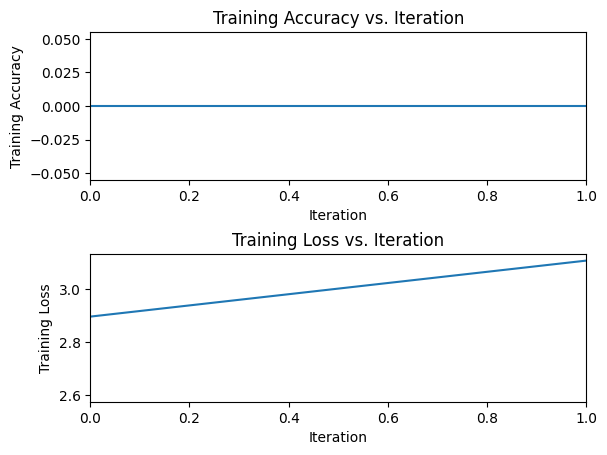

T-patch modules are acting on the input point cloud sequence.
Executing a t-patch module.
Extracting bidirectional t-patches.
S.shape = 4 x 64 x 1024 x 3, Subsampler = <function KMeansSampling at 0x7cafabead000>, M = 12, K = 6, Gaussian Noise ~ (0, 1)
Extracting forward t-patches.
Subsampling 12 points from S_0 of shape 1024 x 3.
Subsampling 12 points from S_0 of shape 1024 x 3.
Subsampling 12 points from S_0 of shape 1024 x 3.
Subsampling 12 points from S_0 of shape 1024 x 3.
Extracting backward t-patches.
Subsampling 12 points from S_T of shape 1024 x 3.
Subsampling 12 points from S_T of shape 1024 x 3.
Subsampling 12 points from S_T of shape 1024 x 3.
Subsampling 12 points from S_T of shape 1024 x 3.
Extracted bidirectional t-patches with shape (4 x 128 x 12 x 18).
Creating high-dimensional feature representation for t-patches of shape (4 x 12 x 128 x 18).
Finished t-patch module execution. 
Created high-dimensional feature representation of shape (4 x 128 x 12 x 8).

Executing a t-

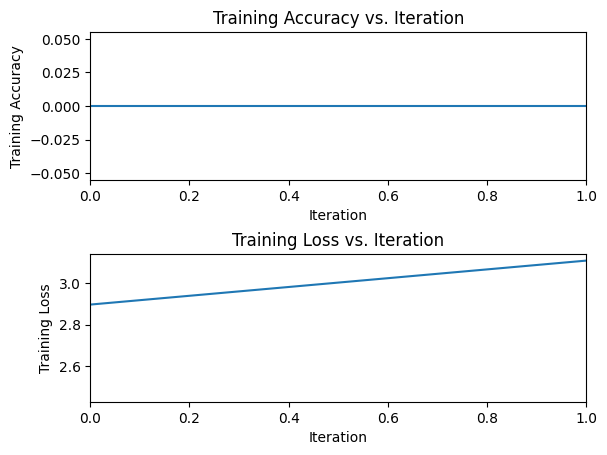

T-patch modules are acting on the input point cloud sequence.
Executing a t-patch module.
Extracting bidirectional t-patches.
S.shape = 4 x 64 x 1024 x 3, Subsampler = <function KMeansSampling at 0x7cafabead000>, M = 12, K = 6, Gaussian Noise ~ (0, 1)
Extracting forward t-patches.
Subsampling 12 points from S_0 of shape 1024 x 3.
Subsampling 12 points from S_0 of shape 1024 x 3.
Subsampling 12 points from S_0 of shape 1024 x 3.
Subsampling 12 points from S_0 of shape 1024 x 3.
Extracting backward t-patches.
Subsampling 12 points from S_T of shape 1024 x 3.
Subsampling 12 points from S_T of shape 1024 x 3.
Subsampling 12 points from S_T of shape 1024 x 3.
Subsampling 12 points from S_T of shape 1024 x 3.
Extracted bidirectional t-patches with shape (4 x 128 x 12 x 18).
Creating high-dimensional feature representation for t-patches of shape (4 x 12 x 128 x 18).
Finished t-patch module execution. 
Created high-dimensional feature representation of shape (4 x 128 x 12 x 8).

Executing a t-

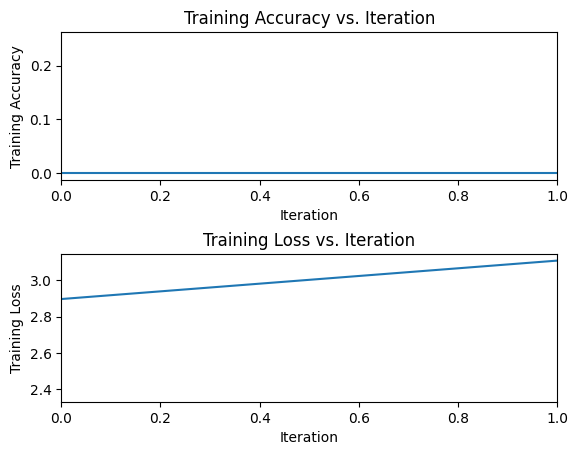

T-patch modules are acting on the input point cloud sequence.
Executing a t-patch module.
Extracting bidirectional t-patches.
S.shape = 4 x 64 x 1024 x 3, Subsampler = <function KMeansSampling at 0x7cafabead000>, M = 12, K = 6, Gaussian Noise ~ (0, 1)
Extracting forward t-patches.
Subsampling 12 points from S_0 of shape 1024 x 3.
Subsampling 12 points from S_0 of shape 1024 x 3.
Subsampling 12 points from S_0 of shape 1024 x 3.
Subsampling 12 points from S_0 of shape 1024 x 3.
Extracting backward t-patches.
Subsampling 12 points from S_T of shape 1024 x 3.
Subsampling 12 points from S_T of shape 1024 x 3.
Subsampling 12 points from S_T of shape 1024 x 3.
Subsampling 12 points from S_T of shape 1024 x 3.
Extracted bidirectional t-patches with shape (4 x 128 x 12 x 18).
Creating high-dimensional feature representation for t-patches of shape (4 x 12 x 128 x 18).
Finished t-patch module execution. 
Created high-dimensional feature representation of shape (4 x 128 x 12 x 8).

Executing a t-

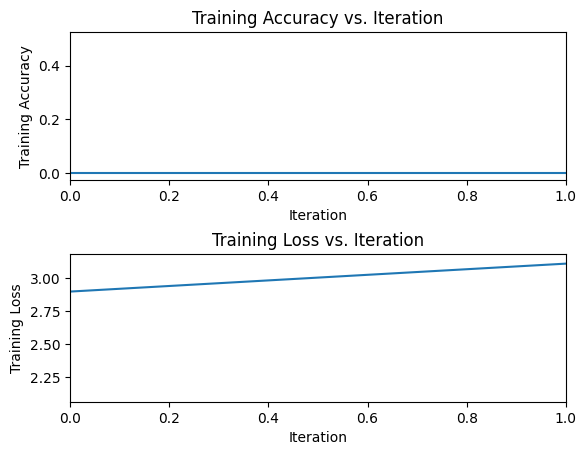

T-patch modules are acting on the input point cloud sequence.
Executing a t-patch module.
Extracting bidirectional t-patches.
S.shape = 4 x 64 x 1024 x 3, Subsampler = <function KMeansSampling at 0x7cafabead000>, M = 12, K = 6, Gaussian Noise ~ (0, 1)
Extracting forward t-patches.
Subsampling 12 points from S_0 of shape 1024 x 3.
Subsampling 12 points from S_0 of shape 1024 x 3.
Subsampling 12 points from S_0 of shape 1024 x 3.
Subsampling 12 points from S_0 of shape 1024 x 3.
Extracting backward t-patches.
Subsampling 12 points from S_T of shape 1024 x 3.
Subsampling 12 points from S_T of shape 1024 x 3.
Subsampling 12 points from S_T of shape 1024 x 3.
Subsampling 12 points from S_T of shape 1024 x 3.
Extracted bidirectional t-patches with shape (4 x 128 x 12 x 18).
Creating high-dimensional feature representation for t-patches of shape (4 x 12 x 128 x 18).
Finished t-patch module execution. 
Created high-dimensional feature representation of shape (4 x 128 x 12 x 8).

Executing a t-

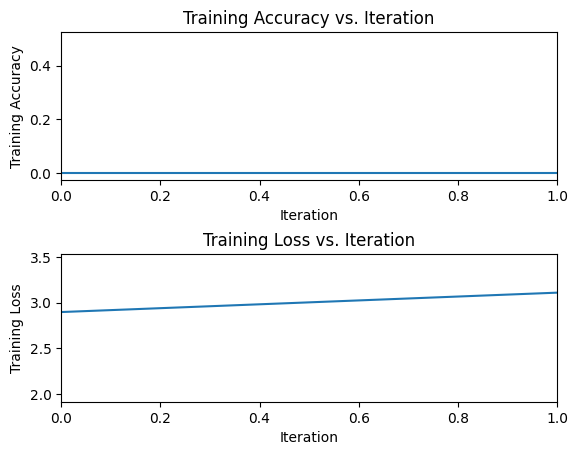

T-patch modules are acting on the input point cloud sequence.
Executing a t-patch module.
Extracting bidirectional t-patches.
S.shape = 4 x 64 x 1024 x 3, Subsampler = <function KMeansSampling at 0x7cafabead000>, M = 12, K = 6, Gaussian Noise ~ (0, 1)
Extracting forward t-patches.
Subsampling 12 points from S_0 of shape 1024 x 3.
Subsampling 12 points from S_0 of shape 1024 x 3.
Subsampling 12 points from S_0 of shape 1024 x 3.
Subsampling 12 points from S_0 of shape 1024 x 3.
Extracting backward t-patches.
Subsampling 12 points from S_T of shape 1024 x 3.
Subsampling 12 points from S_T of shape 1024 x 3.
Subsampling 12 points from S_T of shape 1024 x 3.
Subsampling 12 points from S_T of shape 1024 x 3.
Extracted bidirectional t-patches with shape (4 x 128 x 12 x 18).
Creating high-dimensional feature representation for t-patches of shape (4 x 12 x 128 x 18).
Finished t-patch module execution. 
Created high-dimensional feature representation of shape (4 x 128 x 12 x 8).

Executing a t-

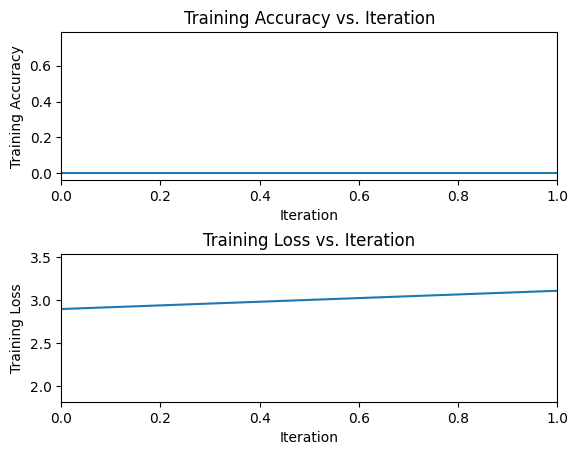

T-patch modules are acting on the input point cloud sequence.
Executing a t-patch module.
Extracting bidirectional t-patches.
S.shape = 4 x 64 x 1024 x 3, Subsampler = <function KMeansSampling at 0x7cafabead000>, M = 12, K = 6, Gaussian Noise ~ (0, 1)
Extracting forward t-patches.
Subsampling 12 points from S_0 of shape 1024 x 3.
Subsampling 12 points from S_0 of shape 1024 x 3.
Subsampling 12 points from S_0 of shape 1024 x 3.
Subsampling 12 points from S_0 of shape 1024 x 3.
Extracting backward t-patches.
Subsampling 12 points from S_T of shape 1024 x 3.
Subsampling 12 points from S_T of shape 1024 x 3.
Subsampling 12 points from S_T of shape 1024 x 3.
Subsampling 12 points from S_T of shape 1024 x 3.
Extracted bidirectional t-patches with shape (4 x 128 x 12 x 18).
Creating high-dimensional feature representation for t-patches of shape (4 x 12 x 128 x 18).
Finished t-patch module execution. 
Created high-dimensional feature representation of shape (4 x 128 x 12 x 8).

Executing a t-

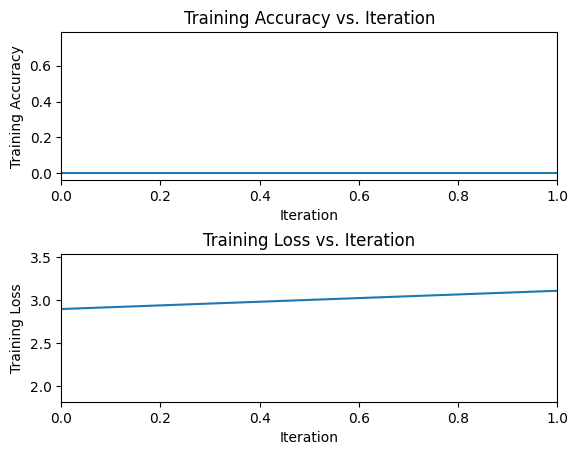

T-patch modules are acting on the input point cloud sequence.
Executing a t-patch module.
Extracting bidirectional t-patches.
S.shape = 4 x 64 x 1024 x 3, Subsampler = <function KMeansSampling at 0x7cafabead000>, M = 12, K = 6, Gaussian Noise ~ (0, 1)
Extracting forward t-patches.
Subsampling 12 points from S_0 of shape 1024 x 3.
Subsampling 12 points from S_0 of shape 1024 x 3.
Subsampling 12 points from S_0 of shape 1024 x 3.
Subsampling 12 points from S_0 of shape 1024 x 3.
Extracting backward t-patches.
Subsampling 12 points from S_T of shape 1024 x 3.
Subsampling 12 points from S_T of shape 1024 x 3.
Subsampling 12 points from S_T of shape 1024 x 3.
Subsampling 12 points from S_T of shape 1024 x 3.
Extracted bidirectional t-patches with shape (4 x 128 x 12 x 18).
Creating high-dimensional feature representation for t-patches of shape (4 x 12 x 128 x 18).
Finished t-patch module execution. 
Created high-dimensional feature representation of shape (4 x 128 x 12 x 8).

Executing a t-

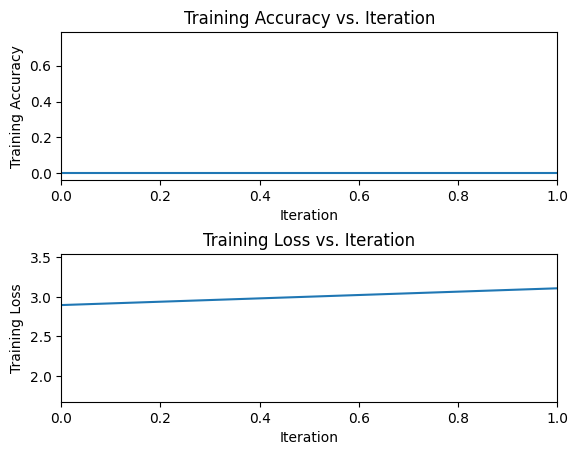

T-patch modules are acting on the input point cloud sequence.
Executing a t-patch module.
Extracting bidirectional t-patches.
S.shape = 4 x 64 x 1024 x 3, Subsampler = <function KMeansSampling at 0x7cafabead000>, M = 12, K = 6, Gaussian Noise ~ (0, 1)
Extracting forward t-patches.
Subsampling 12 points from S_0 of shape 1024 x 3.
Subsampling 12 points from S_0 of shape 1024 x 3.
Subsampling 12 points from S_0 of shape 1024 x 3.
Subsampling 12 points from S_0 of shape 1024 x 3.
Extracting backward t-patches.
Subsampling 12 points from S_T of shape 1024 x 3.
Subsampling 12 points from S_T of shape 1024 x 3.
Subsampling 12 points from S_T of shape 1024 x 3.
Subsampling 12 points from S_T of shape 1024 x 3.
Extracted bidirectional t-patches with shape (4 x 128 x 12 x 18).
Creating high-dimensional feature representation for t-patches of shape (4 x 12 x 128 x 18).
Finished t-patch module execution. 
Created high-dimensional feature representation of shape (4 x 128 x 12 x 8).

Executing a t-

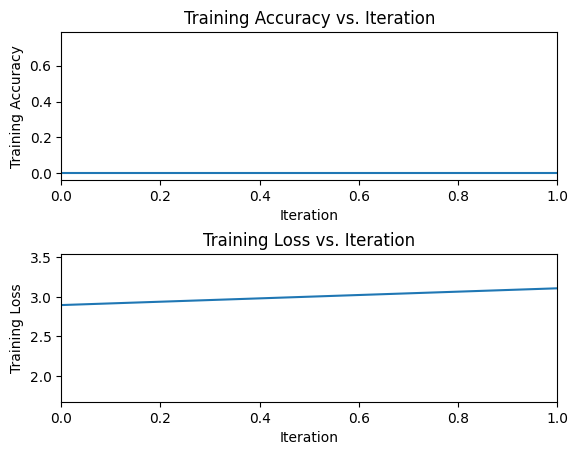

T-patch modules are acting on the input point cloud sequence.
Executing a t-patch module.
Extracting bidirectional t-patches.
S.shape = 4 x 64 x 1024 x 3, Subsampler = <function KMeansSampling at 0x7cafabead000>, M = 12, K = 6, Gaussian Noise ~ (0, 1)
Extracting forward t-patches.
Subsampling 12 points from S_0 of shape 1024 x 3.
Subsampling 12 points from S_0 of shape 1024 x 3.
Subsampling 12 points from S_0 of shape 1024 x 3.
Subsampling 12 points from S_0 of shape 1024 x 3.
Extracting backward t-patches.
Subsampling 12 points from S_T of shape 1024 x 3.
Subsampling 12 points from S_T of shape 1024 x 3.
Subsampling 12 points from S_T of shape 1024 x 3.
Subsampling 12 points from S_T of shape 1024 x 3.
Extracted bidirectional t-patches with shape (4 x 128 x 12 x 18).
Creating high-dimensional feature representation for t-patches of shape (4 x 12 x 128 x 18).
Finished t-patch module execution. 
Created high-dimensional feature representation of shape (4 x 128 x 12 x 8).

Executing a t-

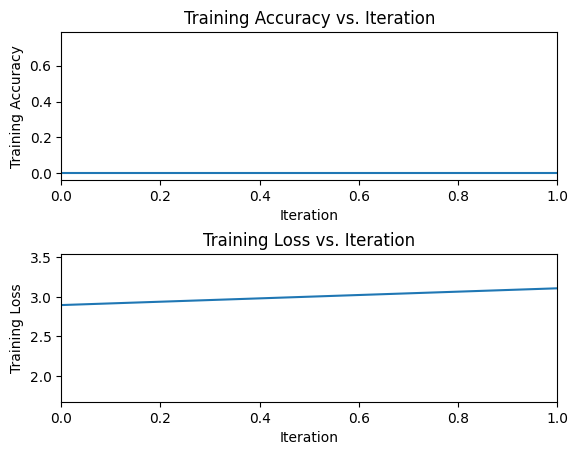

T-patch modules are acting on the input point cloud sequence.
Executing a t-patch module.
Extracting bidirectional t-patches.
S.shape = 4 x 64 x 1024 x 3, Subsampler = <function KMeansSampling at 0x7cafabead000>, M = 12, K = 6, Gaussian Noise ~ (0, 1)
Extracting forward t-patches.
Subsampling 12 points from S_0 of shape 1024 x 3.
Subsampling 12 points from S_0 of shape 1024 x 3.
Subsampling 12 points from S_0 of shape 1024 x 3.
Subsampling 12 points from S_0 of shape 1024 x 3.
Extracting backward t-patches.
Subsampling 12 points from S_T of shape 1024 x 3.
Subsampling 12 points from S_T of shape 1024 x 3.
Subsampling 12 points from S_T of shape 1024 x 3.
Subsampling 12 points from S_T of shape 1024 x 3.
Extracted bidirectional t-patches with shape (4 x 128 x 12 x 18).
Creating high-dimensional feature representation for t-patches of shape (4 x 12 x 128 x 18).
Finished t-patch module execution. 
Created high-dimensional feature representation of shape (4 x 128 x 12 x 8).

Executing a t-

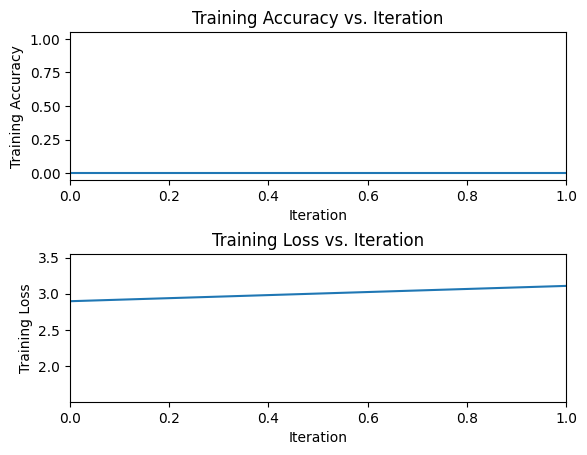

T-patch modules are acting on the input point cloud sequence.
Executing a t-patch module.
Extracting bidirectional t-patches.
S.shape = 4 x 64 x 1024 x 3, Subsampler = <function KMeansSampling at 0x7cafabead000>, M = 12, K = 6, Gaussian Noise ~ (0, 1)
Extracting forward t-patches.
Subsampling 12 points from S_0 of shape 1024 x 3.
Subsampling 12 points from S_0 of shape 1024 x 3.
Subsampling 12 points from S_0 of shape 1024 x 3.
Subsampling 12 points from S_0 of shape 1024 x 3.
Extracting backward t-patches.
Subsampling 12 points from S_T of shape 1024 x 3.
Subsampling 12 points from S_T of shape 1024 x 3.
Subsampling 12 points from S_T of shape 1024 x 3.
Subsampling 12 points from S_T of shape 1024 x 3.
Extracted bidirectional t-patches with shape (4 x 128 x 12 x 18).
Creating high-dimensional feature representation for t-patches of shape (4 x 12 x 128 x 18).
Finished t-patch module execution. 
Created high-dimensional feature representation of shape (4 x 128 x 12 x 8).

Executing a t-

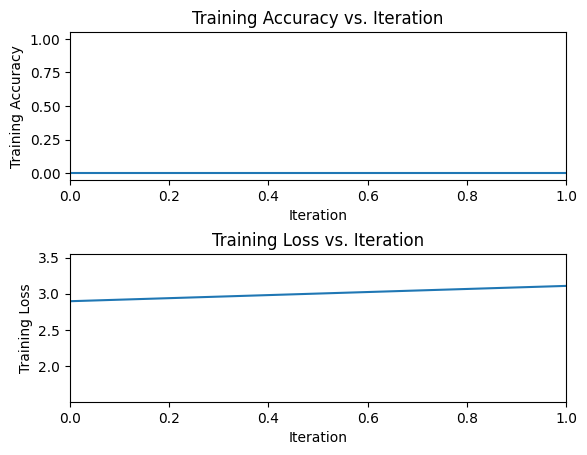

T-patch modules are acting on the input point cloud sequence.
Executing a t-patch module.
Extracting bidirectional t-patches.
S.shape = 4 x 64 x 1024 x 3, Subsampler = <function KMeansSampling at 0x7cafabead000>, M = 12, K = 6, Gaussian Noise ~ (0, 1)
Extracting forward t-patches.
Subsampling 12 points from S_0 of shape 1024 x 3.
Subsampling 12 points from S_0 of shape 1024 x 3.
Subsampling 12 points from S_0 of shape 1024 x 3.
Subsampling 12 points from S_0 of shape 1024 x 3.
Extracting backward t-patches.
Subsampling 12 points from S_T of shape 1024 x 3.
Subsampling 12 points from S_T of shape 1024 x 3.
Subsampling 12 points from S_T of shape 1024 x 3.
Subsampling 12 points from S_T of shape 1024 x 3.
Extracted bidirectional t-patches with shape (4 x 128 x 12 x 18).
Creating high-dimensional feature representation for t-patches of shape (4 x 12 x 128 x 18).
Finished t-patch module execution. 
Created high-dimensional feature representation of shape (4 x 128 x 12 x 8).

Executing a t-

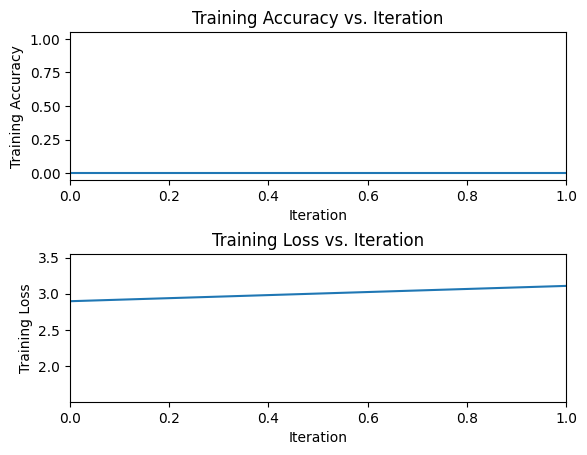

T-patch modules are acting on the input point cloud sequence.
Executing a t-patch module.
Extracting bidirectional t-patches.
S.shape = 4 x 64 x 1024 x 3, Subsampler = <function KMeansSampling at 0x7cafabead000>, M = 12, K = 6, Gaussian Noise ~ (0, 1)
Extracting forward t-patches.
Subsampling 12 points from S_0 of shape 1024 x 3.
Subsampling 12 points from S_0 of shape 1024 x 3.
Subsampling 12 points from S_0 of shape 1024 x 3.
Subsampling 12 points from S_0 of shape 1024 x 3.
Extracting backward t-patches.
Subsampling 12 points from S_T of shape 1024 x 3.
Subsampling 12 points from S_T of shape 1024 x 3.
Subsampling 12 points from S_T of shape 1024 x 3.
Subsampling 12 points from S_T of shape 1024 x 3.
Extracted bidirectional t-patches with shape (4 x 128 x 12 x 18).
Creating high-dimensional feature representation for t-patches of shape (4 x 12 x 128 x 18).
Finished t-patch module execution. 
Created high-dimensional feature representation of shape (4 x 128 x 12 x 8).

Executing a t-

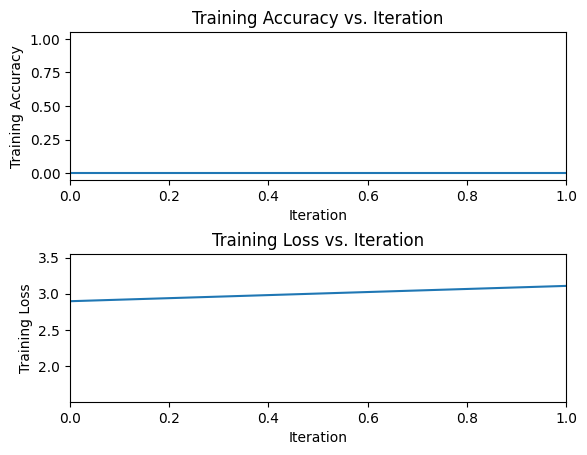

T-patch modules are acting on the input point cloud sequence.
Executing a t-patch module.
Extracting bidirectional t-patches.
S.shape = 4 x 64 x 1024 x 3, Subsampler = <function KMeansSampling at 0x7cafabead000>, M = 12, K = 6, Gaussian Noise ~ (0, 1)
Extracting forward t-patches.
Subsampling 12 points from S_0 of shape 1024 x 3.
Subsampling 12 points from S_0 of shape 1024 x 3.
Subsampling 12 points from S_0 of shape 1024 x 3.
Subsampling 12 points from S_0 of shape 1024 x 3.
Extracting backward t-patches.
Subsampling 12 points from S_T of shape 1024 x 3.
Subsampling 12 points from S_T of shape 1024 x 3.
Subsampling 12 points from S_T of shape 1024 x 3.
Subsampling 12 points from S_T of shape 1024 x 3.
Extracted bidirectional t-patches with shape (4 x 128 x 12 x 18).
Creating high-dimensional feature representation for t-patches of shape (4 x 12 x 128 x 18).
Finished t-patch module execution. 
Created high-dimensional feature representation of shape (4 x 128 x 12 x 8).

Executing a t-

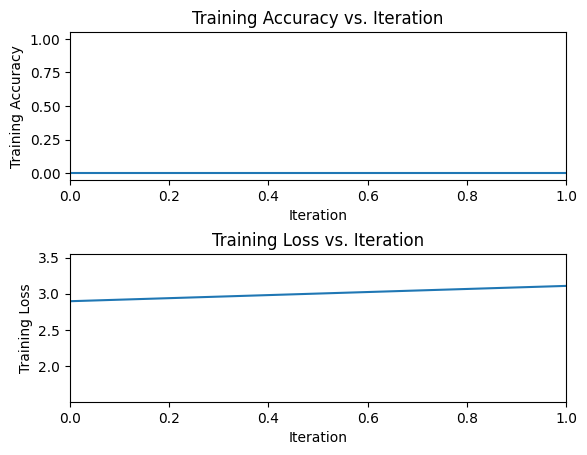

T-patch modules are acting on the input point cloud sequence.
Executing a t-patch module.
Extracting bidirectional t-patches.
S.shape = 4 x 64 x 1024 x 3, Subsampler = <function KMeansSampling at 0x7cafabead000>, M = 12, K = 6, Gaussian Noise ~ (0, 1)
Extracting forward t-patches.
Subsampling 12 points from S_0 of shape 1024 x 3.
Subsampling 12 points from S_0 of shape 1024 x 3.
Subsampling 12 points from S_0 of shape 1024 x 3.
Subsampling 12 points from S_0 of shape 1024 x 3.
Extracting backward t-patches.
Subsampling 12 points from S_T of shape 1024 x 3.
Subsampling 12 points from S_T of shape 1024 x 3.
Subsampling 12 points from S_T of shape 1024 x 3.
Subsampling 12 points from S_T of shape 1024 x 3.
Extracted bidirectional t-patches with shape (4 x 128 x 12 x 18).
Creating high-dimensional feature representation for t-patches of shape (4 x 12 x 128 x 18).
Finished t-patch module execution. 
Created high-dimensional feature representation of shape (4 x 128 x 12 x 8).

Executing a t-

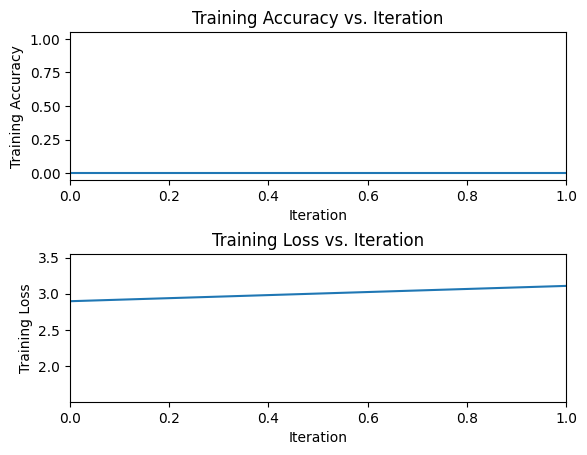

T-patch modules are acting on the input point cloud sequence.
Executing a t-patch module.
Extracting bidirectional t-patches.
S.shape = 4 x 64 x 1024 x 3, Subsampler = <function KMeansSampling at 0x7cafabead000>, M = 12, K = 6, Gaussian Noise ~ (0, 1)
Extracting forward t-patches.
Subsampling 12 points from S_0 of shape 1024 x 3.
Subsampling 12 points from S_0 of shape 1024 x 3.
Subsampling 12 points from S_0 of shape 1024 x 3.
Subsampling 12 points from S_0 of shape 1024 x 3.
Extracting backward t-patches.
Subsampling 12 points from S_T of shape 1024 x 3.
Subsampling 12 points from S_T of shape 1024 x 3.
Subsampling 12 points from S_T of shape 1024 x 3.
Subsampling 12 points from S_T of shape 1024 x 3.
Extracted bidirectional t-patches with shape (4 x 128 x 12 x 18).
Creating high-dimensional feature representation for t-patches of shape (4 x 12 x 128 x 18).
Finished t-patch module execution. 
Created high-dimensional feature representation of shape (4 x 128 x 12 x 8).

Executing a t-

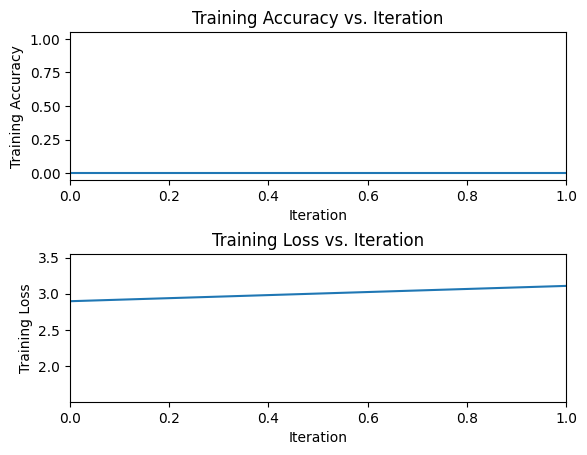

T-patch modules are acting on the input point cloud sequence.
Executing a t-patch module.
Extracting bidirectional t-patches.
S.shape = 4 x 64 x 1024 x 3, Subsampler = <function KMeansSampling at 0x7cafabead000>, M = 12, K = 6, Gaussian Noise ~ (0, 1)
Extracting forward t-patches.
Subsampling 12 points from S_0 of shape 1024 x 3.
Subsampling 12 points from S_0 of shape 1024 x 3.
Subsampling 12 points from S_0 of shape 1024 x 3.
Subsampling 12 points from S_0 of shape 1024 x 3.
Extracting backward t-patches.
Subsampling 12 points from S_T of shape 1024 x 3.
Subsampling 12 points from S_T of shape 1024 x 3.
Subsampling 12 points from S_T of shape 1024 x 3.
Subsampling 12 points from S_T of shape 1024 x 3.
Extracted bidirectional t-patches with shape (4 x 128 x 12 x 18).
Creating high-dimensional feature representation for t-patches of shape (4 x 12 x 128 x 18).
Finished t-patch module execution. 
Created high-dimensional feature representation of shape (4 x 128 x 12 x 8).

Executing a t-

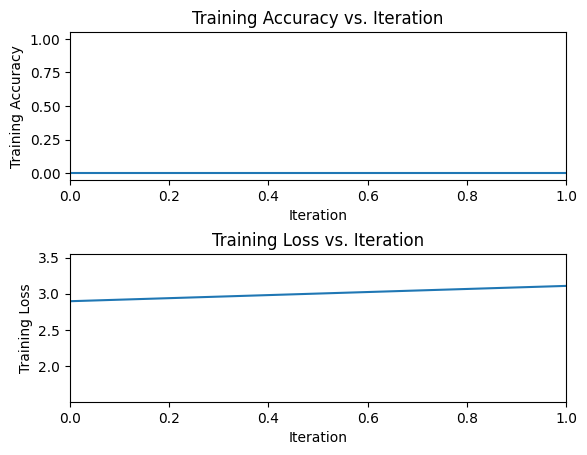

T-patch modules are acting on the input point cloud sequence.
Executing a t-patch module.
Extracting bidirectional t-patches.
S.shape = 4 x 64 x 1024 x 3, Subsampler = <function KMeansSampling at 0x7cafabead000>, M = 12, K = 6, Gaussian Noise ~ (0, 1)
Extracting forward t-patches.
Subsampling 12 points from S_0 of shape 1024 x 3.
Subsampling 12 points from S_0 of shape 1024 x 3.
Subsampling 12 points from S_0 of shape 1024 x 3.
Subsampling 12 points from S_0 of shape 1024 x 3.
Extracting backward t-patches.
Subsampling 12 points from S_T of shape 1024 x 3.
Subsampling 12 points from S_T of shape 1024 x 3.
Subsampling 12 points from S_T of shape 1024 x 3.
Subsampling 12 points from S_T of shape 1024 x 3.
Extracted bidirectional t-patches with shape (4 x 128 x 12 x 18).
Creating high-dimensional feature representation for t-patches of shape (4 x 12 x 128 x 18).
Finished t-patch module execution. 
Created high-dimensional feature representation of shape (4 x 128 x 12 x 8).

Executing a t-

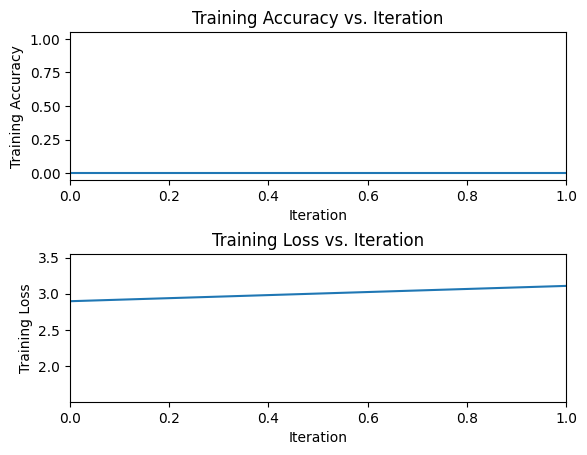

T-patch modules are acting on the input point cloud sequence.
Executing a t-patch module.
Extracting bidirectional t-patches.
S.shape = 4 x 64 x 1024 x 3, Subsampler = <function KMeansSampling at 0x7cafabead000>, M = 12, K = 6, Gaussian Noise ~ (0, 1)
Extracting forward t-patches.
Subsampling 12 points from S_0 of shape 1024 x 3.
Subsampling 12 points from S_0 of shape 1024 x 3.
Subsampling 12 points from S_0 of shape 1024 x 3.
Subsampling 12 points from S_0 of shape 1024 x 3.
Extracting backward t-patches.
Subsampling 12 points from S_T of shape 1024 x 3.
Subsampling 12 points from S_T of shape 1024 x 3.
Subsampling 12 points from S_T of shape 1024 x 3.
Subsampling 12 points from S_T of shape 1024 x 3.
Extracted bidirectional t-patches with shape (4 x 128 x 12 x 18).
Creating high-dimensional feature representation for t-patches of shape (4 x 12 x 128 x 18).
Finished t-patch module execution. 
Created high-dimensional feature representation of shape (4 x 128 x 12 x 8).

Executing a t-

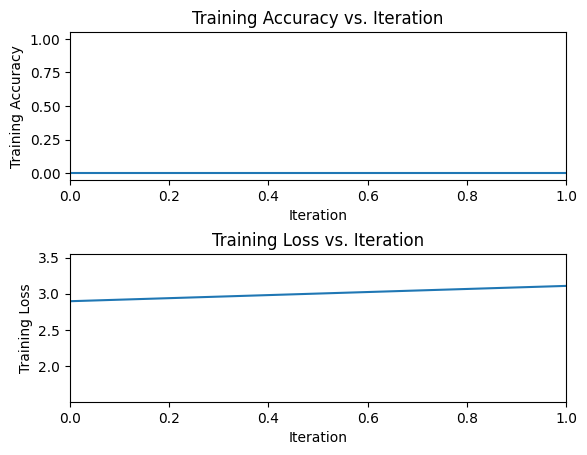

In [ ]:
# Store the training losses and accuracies in a variable.
training_losses_and_accuracies = []

# Store the number of training epochs in a variable.
# Currently, 3 epochs and ~20% training accuracy.
number_epochs = 20

for epoch in range(number_epochs):
  for batch_index, batch in enumerate(training_data_loader):
    # Get the clips in the current batch and its labels.
    labels, clips = batch

    # Put the model in training mode.
    action_classification_model.train()

    # Make predictions using the model.
    action_predictions = action_classification_model(clips).to(this_device)

    # Store the per frame losses for the model predictions of action classes.
    per_frame_losses = frame_loss(
      action_predictions,
       (
           labels.to(dtype = torch.long).unsqueeze(1) + torch.zeros((clips.shape[0], clip_size), dtype = torch.long, device = this_device)
       ).to(device = this_device)
      ).to(device = this_device)

    # Nullify the gradients of the loss by the model parameters.
    model_optimizer.zero_grad()

    # Do backpropagation.
    per_frame_losses.backward()

    # Update the model parameters.
    model_optimizer.step()

    # Print out the losses.
    print("Epoch {}, Batch {}, Training Loss: {}".format(epoch + 1, batch_index + 1, per_frame_losses.item()))

    # Calculate the training accuracy and store it in a variable.
    action_predictions = torch.mode(torch.max(action_predictions, dim = 1)[1], dim = 1)[0]
    training_accuracy = torch.sum(action_predictions == labels) / action_predictions.shape[0]

    # If the current training accuracy is better than all times before,
    # update the best 3D In Action model.
    if best_training_accuracy < training_accuracy:
      # Print out that a better 3D in action model was made.
      print("A better 3D in action model has been made.")
      best_training_accuracy = training_accuracy
      best_3d_in_action_model = action_classification_model

    # Print out the training accuracy.
    print("Epoch {}, Batch {}, Training accuracy: {:%}\n\n".format(epoch + 1, batch_index + 1, training_accuracy))
    print("===============================================")

    # Store the training loss and the training accuracy of the current batch in the list of losses and accuracies.
    training_losses_and_accuracies.append((per_frame_losses.item(), training_accuracy))

    if dataset_used == "MSR-Action3D":
      # Save the best 3D in Action model to a file and how many epochs it was trained to a file. Also, save the best training accuracy to a file.
      torch.save((best_3d_in_action_model.state_dict(), num_trained_epochs, best_training_accuracy),
      '/content/drive/MyDrive/Colab Notebooks/COMPSCI 674/Final Project/MSRAction3DFPS/MSRAction3D.pt')
    else:
      # Save the best 3D in Action model to a file and how many epochs it was trained to a file. Also, save the best training accuracy to a file.
      torch.save((best_3d_in_action_model.state_dict(), num_trained_epochs, best_training_accuracy),
      '/content/drive/MyDrive/Colab Notebooks/COMPSCI 674/Final Project/DFAUST/downloads/scans/50020/DFAUST.pt')

  # Plot the losses and accuracies.
  draw_losses_and_accuracies()

  # Increment the number of epochs the best model has been trained.
  num_trained_epochs += 1